In [175]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
# import tensorflow
import keras
from keras.models import Sequential,Model,load_model



In [176]:
model_NN = keras.models.load_model('XeBRA_Position_Reconstruction_NN_Model.h5')

In [200]:
ctx.data_info('event_basics')
#ctx.data_info('peak_positions')

Field name Data type  \
0                n_peaks     int32   
1             drift_time     int64   
2               s1_index     int32   
3                s1_area   float32   
4              s1_area_b   float32   
5   s1_area_fraction_top   float32   
6      s1_range_50p_area   float32   
7         s1_n_competing     int32   
8               s2_index     int32   
9                s2_area   float32   
10             s2_area_b   float32   
11  s2_area_fraction_top   float32   
12     s2_range_50p_area   float32   
13        s2_n_competing     int32   
14                  x_s2   float32   
15                  y_s2   float32   
16      s2_largest_other   float32   
17      s1_largest_other   float32   

                                              Comment  
0                        Number of peaks in the event  
1             Drift time between main S1 and S2 in ns  
2                                  Main S1 peak index  
3                      Main S1 area (PE), uncorrected  
4    Main S1 area (PE), uncorrected, bottom PMTs only  
5                           Main S1 area fraction top  
6                        Main S1 width (ns, 50% area)  
7                   Main S1 number of competing peaks  
8                                  Main S2 peak index  
9                      Main S2 area (PE), uncorrected  
10   Main S2 area (PE), uncorrected, bottom PMTs only  
11                          Main S2 area fraction top  
12                       Main S2 width (ns, 50% area)  
13                  Main S2 number of competing peaks  
14  Main S2 reconstructed X position (cm), uncorre...  
15  Main S2 reconstructed Y position (cm), uncorre...  
16                           Area of largest other s2  
17                           Area of largest other s1

In [178]:
run_list = ['00177', '00179', '00178', '00175']
#run_list = ['00178']
#############[pos2, pos3, pos0]###########
integral_all_runs = {}
risetime_all_runs = {}
cut_integral_all_runs = {}
cut_width_all_runs = {}
width_all_runs = {}
cs_s2_index_all_runs = {}

PMTs_S1_all_runs = {}
PMTs_S2_all_runs = {}
PMTs_S1_corrected_all_runs = {}
PMTs_S2_corrected_all_runs = {}

cs_s1_area_all_runs = {}
cs_s1_area_corrected_all_runs = {}
cs_s2_area_all_runs = {}
cs_s2_area_corrected_all_runs = {}

cs_s1_width_all_runs = {}
cs_s1_width_corrected_all_runs = {}
cs_s2_width_all_runs = {}
cs_s2_width_corrected_all_runs = {}

cs_s1_risetime_all_runs = {}
cs_s1_risetime_corrected_all_runs = {}
cs_s2_risetime_all_runs = {}
cs_s2_risetime_corrected_all_runs = {}

cs_first_S2_area_all_runs = {}
cs_first_S2_width_all_runs = {}
cs_first_S2_risetime_all_runs = {}
cs_second_S2_area_all_runs = {}
cs_second_S2_width_all_runs = {}
cs_second_S2_risetime_all_runs = {}

cs_x_position_all_runs = {}
cs_y_position_all_runs = {}

cs_x_position_raw_all_runs = {}
cs_y_position_raw_all_runs = {}

cs_drifttime_all_runs = {}

for run in run_list:
    def CutCondition(integral, width, i):
        if integral[i] > 100 and integral[i] < 4000 and width[i] > 30 and width[i] < 50:
            return(True)
        else:
            return(False)
        
    def PrintWaveform(waveform,width,i):
    
        fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1,7,sharex=False, figsize=(30, 5))
        ax1.plot(waveform[i])
        ax2.plot(waveform[i+1])
        ax3.plot(waveform[i+2])
        ax4.plot(waveform[i+3])
        ax5.plot(waveform[i+4])
        ax6.plot(waveform[i+5])
        ax7.plot(waveform[i+6])
        plt.show()
        

    
    def S2_found(integral, width):
        #maximum_S2 = max(waveform)
        if integral > 500 and width >200 and width < 2000:
            return True
        else:
            return False
        
    def reconstructed_position(input_array):
        ## Normalize sum input to 1 in order to correspond to area fraction in top array
        HFs_input = input_array / np.sum(input_array)
        ## Use model to reconstruct position
        ## Important: Factor 70 for rescaling label
        predictions = model_NN.predict(np.array(HFs_input))*70
        return predictions
    
    def Process(waveform, i): 
        SelectionCutFlag = CutCondition(integral, width, i)
        if SelectionCutFlag == True:
            j = 1
            counter_timestamp = timestamp[i+j]
            threshold_timestamp = timestamp[i] + 45000
            while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
                j += 1
                counter_timestamp = timestamp[i+j]
            else:
                if S2_found(integral = integral[i+j], width = width[i+j]):
#                 PrintWaveform_kr_s1(waveform, i)
                    cs_s1_area.append(integral[i])
                    cs_s1_width.append(width[i])
                    cs_s1_risetime.append(risetime[i])
            
                    cs_s2_area.append(integral[i+j])
                    cs_s2_width.append(width[i+j])
                    cs_s2_risetime.append(risetime[i+j])
                    
                    cs_s2_index.append(j)
                    
                    for m in range(len(PMT_S1_area_list)):
                        if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
                        and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
                        and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
                        and area_per_channel[i+j][7] > 0 \
                        :
                            PMT_S1_area_list[m].append(area_per_channel[i][m+1])
                            PMT_S2_area_list[m].append(area_per_channel[i+j][m+1])
                   
                    k=1 
                    s2_counter_timestamp = timestamp[i+j+k]
                    while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                        k += 1
                        s2_counter_timestamp = timestamp[i+j+k]
                    else:
                        if S2_found(integral = integral[i+j+k], width = width[i+j+k]):
#                             PrintWaveform(waveform, i)
#                             print('first S2: ', j, ' ,second S2: ', j+k)
                            
    
                            cs_first_S2_area.append(integral[i+j])
                            cs_first_S2_width.append(width[i+j])
                            cs_first_S2_risetime.append(risetime[i+j])
                            cs_second_S2_area.append(integral[i+j+k])
                            cs_second_S2_width.append(width[i+j+k])
                            cs_second_S2_risetime.append(risetime[i+j+k])

                
                        if threshold_timestamp <= s2_counter_timestamp:
                            
                            cs_s1_area_corrected.append(integral[i])
                            cs_s1_width_corrected.append(width[i])
                            cs_s1_risetime_corrected.append(risetime[i])
                                                      
                            cs_s2_area_corrected.append(integral[i+j])
                            cs_s2_width_corrected.append(width[i+j])
                            cs_s2_risetime_corrected.append(risetime[i+j]) 
                            
                            cs_x_position.append(x_position[i+j])
                            cs_y_position.append(y_position[i+j])
                            time = threshold_timestamp - timestamp[i+j]
                            drifttime.append(time)
                            


                            
                            for m in range(len(PMT_S1_area_list)):
                                if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
                                and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
                                and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
                                and area_per_channel[i+j][7] > 0 \
                                :
                                    PMT_S1_area_list_corrected[m].append(area_per_channel[i][m+1])
                                    PMT_S2_area_list_corrected[m].append(area_per_channel[i+j][m+1])
                                    
                            
#                             input_array = np.array(PMT_S2_area_list_corrected)
#                             input_array_final = input_array.T

#                             positions = reconstructed_position(input_array_final)
#                             x_position_raw = positions[:,0]
#                             x_position_raw = list(x_position_raw)
#                             x_positions.append(x_position_raw)
#                             y_position_raw = positions[:,1]
#                             y_position_raw = list(y_position_raw)
#                             y_positions.append(y_position_raw)
                            
#                             PMTs_input_list = PMT_S1_area_list_corrected
#                             PMTs_input_array = np.array(PMT_S1_area_list_corrected)
#                             PMTs_input = PMTs_input.T
#                             positions = reconstructed_position(PMTs_input)
#                             print(positions)
                            

                    
                    return
                else:
                    return

    ctx = straxbra.XebraContext()

    peaks_data = ctx.get_array(run, 'peaks')
    position_data = ctx.get_array(run, 'peak_positions')
    waveform = peaks_data['data']
    integral = peaks_data['area']
    width = peaks_data['width'][:,5]
    timestamp = peaks_data['time']
    risetime = -peaks_data['area_decile_from_midpoint'][:,1]
    area_per_channel = peaks_data['area_per_channel']
    x_position = position_data['x']
    y_position = position_data['y']
    
    integral_all_runs.update({run:integral})
    width_all_runs.update({run:width})
    risetime_all_runs.update({run:risetime})
    
    cs_s2_index = []
    
    cs_s1_area = []
    cs_s1_width = []
    cs_s1_risetime = []
    
    cs_s2_area = []
    cs_s2_width = []
    cs_s2_risetime = []
    
    cs_s1_area_corrected = [] 
    cs_s1_width_corrected = []   
    cs_s1_risetime_corrected = []
    
    cs_s2_area_corrected = []
    cs_s2_width_corrected = []
    cs_s2_risetime_corrected = []
    
    cs_first_S2_area = []
    cs_first_S2_width = []
    cs_first_S2_risetime = []
    
    cs_second_S2_area = []
    cs_second_S2_width = []
    cs_second_S2_risetime = []
    
    cs_x_position = []
    cs_y_position = []
         
    drifttime = []
    #PMTs_input_array = []
                                                                 
                                                                 
                                                                 
                                                                 
    Area_s2_PMT1 = []
    Area_s2_PMT2 = []
    Area_s2_PMT3 = []
    Area_s2_PMT4 = []
    Area_s2_PMT5 = []
    Area_s2_PMT6 = []
    Area_s2_PMT7 = []
                                                                 
    Area_s1_PMT1 = []
    Area_s1_PMT2 = []
    Area_s1_PMT3 = []
    Area_s1_PMT4 = []
    Area_s1_PMT5 = []
    Area_s1_PMT6 = []
    Area_s1_PMT7 = [] 
                                                                 
    Area_s1_PMT1_corrected = []
    Area_s1_PMT2_corrected = []
    Area_s1_PMT3_corrected = []
    Area_s1_PMT4_corrected = []
    Area_s1_PMT5_corrected = []
    Area_s1_PMT6_corrected = []
    Area_s1_PMT7_corrected = []
                                                                 
    Area_s2_PMT1_corrected = []
    Area_s2_PMT2_corrected = []
    Area_s2_PMT3_corrected = []
    Area_s2_PMT4_corrected = []
    Area_s2_PMT5_corrected = []
    Area_s2_PMT6_corrected = []
    Area_s2_PMT7_corrected = []  
    
    x_positions = []
    y_positions = []
                                                                 
    PMT_S2_area_list = [Area_s2_PMT1, Area_s2_PMT2,Area_s2_PMT3,Area_s2_PMT4,Area_s2_PMT5,Area_s2_PMT6,Area_s2_PMT7]                                                       
    PMT_S1_area_list = [Area_s1_PMT1, Area_s1_PMT2,Area_s1_PMT3,Area_s1_PMT4,Area_s1_PMT5,Area_s1_PMT6,Area_s1_PMT7]                                                             
    PMT_S2_area_list_corrected = [Area_s2_PMT1_corrected, Area_s2_PMT2_corrected,Area_s2_PMT3_corrected,Area_s2_PMT4_corrected,Area_s2_PMT5_corrected,Area_s2_PMT6_corrected,Area_s2_PMT7_corrected]  
    PMT_S1_area_list_corrected = [Area_s1_PMT1_corrected, Area_s1_PMT2_corrected,Area_s1_PMT3_corrected,Area_s1_PMT4_corrected,Area_s1_PMT5_corrected,Area_s1_PMT6_corrected,Area_s1_PMT7_corrected]
     
                                                              
    num = len(waveform)
    print_counter = 0.0
    for i in range(0,num):    
        Process(waveform,i)
        if i/num >= print_counter:
            print(round(print_counter,2), end = ' ')
            print_counter += 0.1
    print(1.0)
    
    

    cs_s2_index_all_runs.update({run:cs_s2_index})
    
    cs_s1_area_all_runs.update({run:cs_s1_area})
    cs_s1_area_corrected_all_runs.update({run:cs_s1_area_corrected})
    cs_s2_area_all_runs.update({run:cs_s2_area})
    cs_s2_area_corrected_all_runs.update({run:cs_s2_area_corrected})
    
    cs_s1_width_all_runs.update({run:cs_s1_width})
    cs_s1_width_corrected_all_runs.update({run:cs_s1_width_corrected})
    cs_s2_width_all_runs.update({run:cs_s2_width})
    cs_s2_width_corrected_all_runs.update({run:cs_s2_width_corrected})
    
    cs_s1_risetime_all_runs.update({run:cs_s1_risetime})
    cs_s1_risetime_corrected_all_runs.update({run:cs_s1_risetime_corrected})
    cs_s2_risetime_all_runs.update({run:cs_s2_risetime})
    cs_s2_risetime_corrected_all_runs.update({run:cs_s2_risetime_corrected})
    
    cs_first_S2_area_all_runs.update({run:cs_first_S2_area})
    cs_first_S2_width_all_runs.update({run:cs_first_S2_width})
    cs_first_S2_risetime_all_runs.update({run:cs_first_S2_risetime})
    
    cs_second_S2_area_all_runs.update({run:cs_second_S2_area})
    cs_second_S2_width_all_runs.update({run:cs_second_S2_width})
    cs_second_S2_risetime_all_runs.update({run:cs_second_S2_risetime})
    
    cs_x_position_all_runs.update({run:cs_x_position})
    cs_y_position_all_runs.update({run:cs_y_position})
    cs_drifttime_all_runs.update({run:drifttime})
    
    PMTs_S1_all_runs.update({run:PMT_S1_area_list})
    PMTs_S2_all_runs.update({run:PMT_S2_area_list}) 
    PMTs_S1_corrected_all_runs.update({run:PMT_S1_area_list_corrected}) 
    PMTs_S2_corrected_all_runs.update({run:PMT_S2_area_list_corrected}) 
    
    
#     input_array = np.array(PMTs_S2_corrected_all_runs[run])
#     input_array = np.array(PMT_S2_area_list_corrected)
#     input_array_final = input_array.T

#     positions = reconstructed_position(input_array_final)
#     x_position_raw = positions[:,0]
#     y_position_raw = positions[:,1]  
    
#     cs_x_position_raw_all_runs.update({run:x_position_raw})
#     cs_y_position_raw_all_runs.update({run:y_position_raw})

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0


In [179]:
# print(PMT_S2_area_list_corrected)
# print(len(PMT_S2_area_list_corrected))
# print(type(PMT_S2_area_list_corrected))
# PMT_S2_area_list_corrected = np.array(PMT_S2_area_list_corrected)
# print(type(PMT_S2_area_list_corrected))
# PMT_S2_area_list_corrected.shape
# # b=PMT_S1_area_list_corrected.T
# # print(b.shape)
# # print(b)
# # print(PMTs_input_array)
# #print(PMTs_input_array.shape

# # print(len(cs_s2_area_corrected_all_runs['00178']))
# # print(len(cs_first_S2_area_all_runs['00178']))
# # print(len(cs_second_S2_area_all_runs['00178']))

In [180]:
# print(PMT_S2_area_list_corrected.shape)
# print(len(x_position))
#x_positions

In [181]:
#print(len(x_positions))
#print(x_positions[1])
#print(x_positions[1])

# #model = load_model('XeBRA_Position_Reconstruction_NN_Model.h5')

# def reconstructed_position(input_array):
#     ## Normalize sum input to 1 in order to correspond to area fraction in top array
#     HFs_input = input_array / np.sum(input_array)
#     ## Use model to reconstruct position
#     ## Important: Factor 70 for rescaling label
#     predictions = model_NN.predict(np.array(HFs_input))*70
    

#     return predictions




# #HFs_input = input_array / np.sum(input_array)
# # print(HFs_input)

# # print(sum(input_array))
# # print(input_array)
# # print(input_array.shape)


# input_array = np.array(PMT_S2_area_list_corrected)
# input_array_final = input_array.T
# print(input_array_final.shape)
# # print(input_array_final.shape)
# # print(type(input_array_final))
# # predictions = model.predict(input_array_final)
# # scaling_factor = 70
# # predictions = predictions*scaling_factor
# # print(predictions)

# positions = reconstructed_position(input_array_final)
# x_position = positions[:,0]
# y_position = positions[:,1] 
# x_position = list(x_position)
# #print(x_position)

# Compare cs with background - first orientation

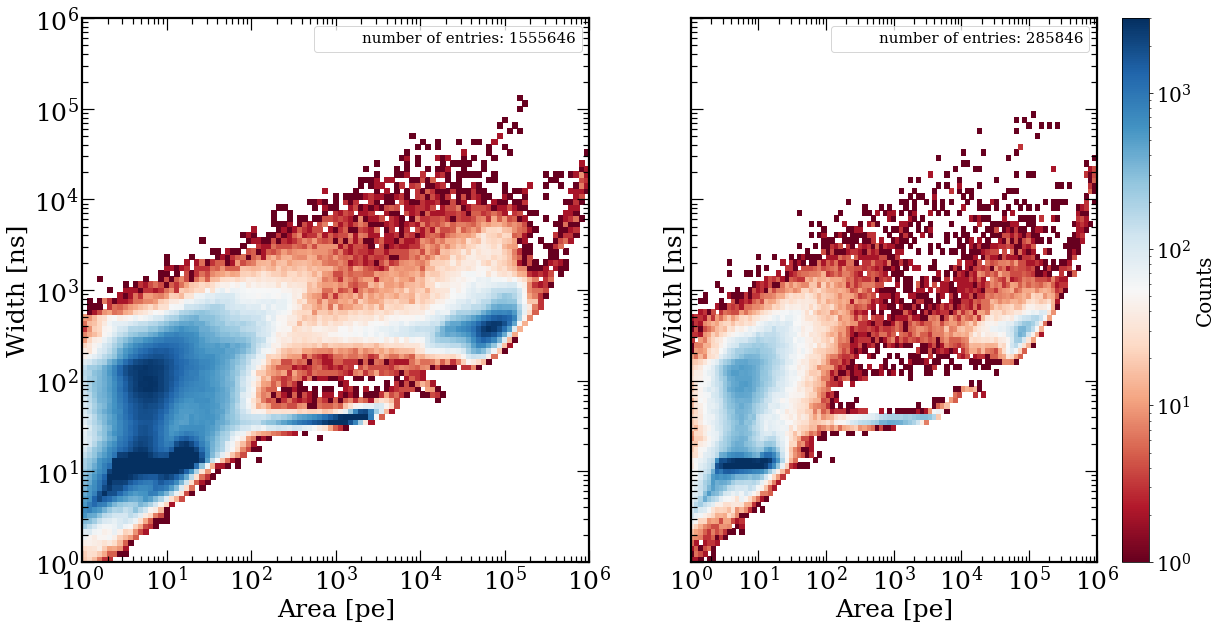

In [182]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(20,10),sharex=True, sharey=True)


plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20




axes1.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes1.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes1.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.yaxis.set_minor_locator(AutoMinorLocator(5))
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

axes2.tick_params(axis='both')

for axis in ['top','bottom','left','right']:
    axes2.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes2.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins_x = np.logspace(0,6,100)
bins_y = np.logspace(0,6,100)
histo_max= 2*10**3



counts_cs, _, _ = np.histogram2d(integral_all_runs['00178'], width_all_runs['00178'], bins=(bins_x, bins_y))
counts_bk, _, _ = np.histogram2d(integral_all_runs['00175'], width_all_runs['00175'], bins=(bins_x, bins_y))

# counts_cs, _, _ = np.histogram2d(integral_all_runs['00178'], width_all_runs['00178'], bins=(bins_x, bins_y))
# counts_bk, _, _ = np.histogram2d(cut_integral_all_runs['00175'], cut_width_all_runs['00175'], bins=(bins_x, bins_y))


im = axes1.pcolormesh(bins_x, bins_y, counts_cs.T, norm=mpl.colors.LogNorm(), vmax=3e3, cmap = 'RdBu')
im = axes2.pcolormesh(bins_x, bins_y, counts_bk.T, norm=mpl.colors.LogNorm(), vmax=3e3, cmap = 'RdBu')
cb = plt.colorbar(im, ax=axes2, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20)
axes1.plot([], [], ' ', label="number of entries: "+str(len(integral_all_runs['00178'])))
axes2.plot([], [], ' ', label="number of entries: "+str(len(integral_all_runs['00175'])))
axes1.set_xscale('log')
axes1.set_yscale('log')
axes1.set_xlabel('Area [pe]')
axes1.set_ylabel('Width [ns]')
axes2.set_xscale('log')
axes2.set_yscale('log')
axes2.set_xlabel('Area [pe]')
axes2.set_ylabel('Width [ns]')
axes1.legend(loc = 1, prop={'size': 15})
axes2.legend(loc = 1, prop={'size': 15})
plt.show()


## Is there a difference in the number of trash waveforms in between an S1 and an S2?

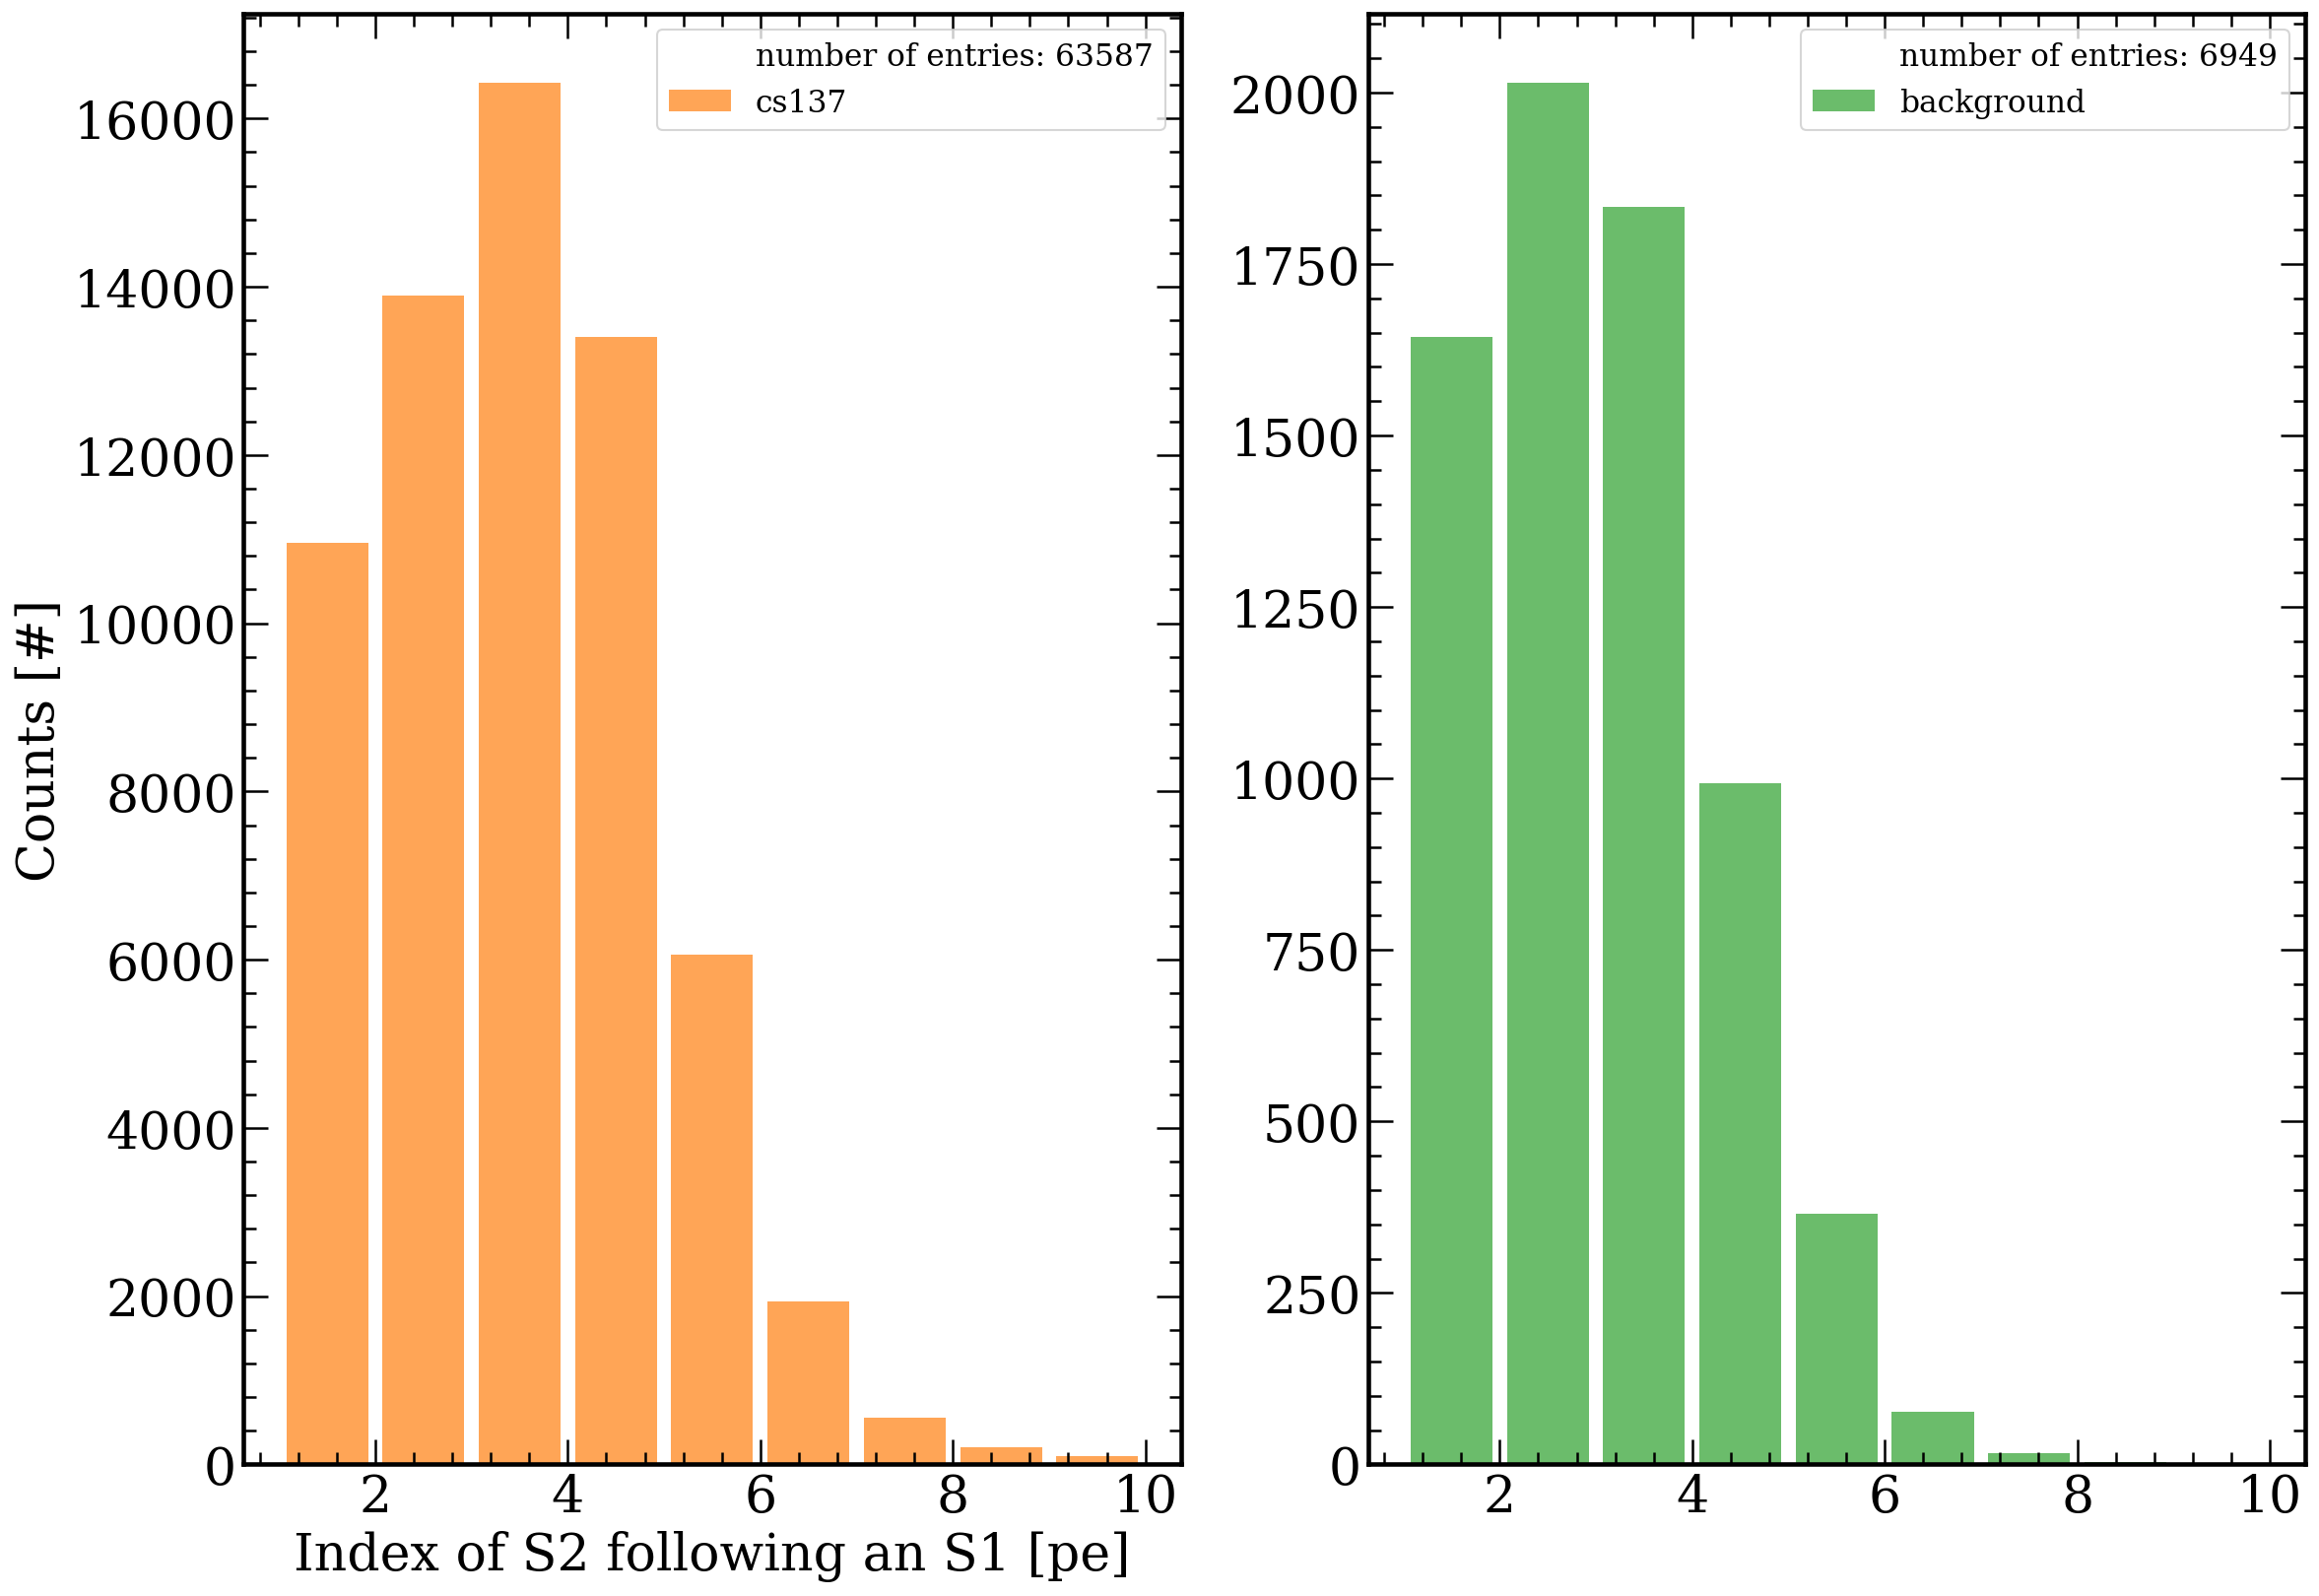

In [183]:
fig, (axes1, axes2)=plt.subplots(1,2,figsize=(18, 13), dpi=150, sharex = True)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters

axes1.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes1.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes1.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.yaxis.set_minor_locator(AutoMinorLocator(5))
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

axes2.tick_params(axis='both')

for axis in ['top','bottom','left','right']:
    axes2.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes2.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

counts_cs, binEdgesCs137 = np.histogram(cs_s2_index_all_runs['00178'], bins=np.linspace(1,10,11))
# bincenters_double_scatter = 0.5 * (binEdgesCs137[1:] + binEdgesCs137[:-1])

counts_bkg, binEdgesBackground = np.histogram(cs_s2_index_all_runs['00175'], bins=np.linspace(1,10,11))
# bincenters_no_scatter_cut = 0.5 * (binEdgesBackground[1:] + binEdgesBackground[:-1])

x_bins = np.linspace(1,10,10)
# print(x_bins)
# print(n)
#axes1.scatter(x_bins, counts_cs, c ='b', s=100, marker = 'x', label = 'cs137')
#axes2.scatter(x_bins, counts_bkg, c ='g', s=100, marker = 'x', label = 'background')
axes1.hist(cs_s2_index_all_runs['00178'], x_bins,rwidth=0.85, color='C1', alpha = 0.7, label= 'cs137')
axes1.plot([], [], ' ', label="number of entries: "+str(len(cs_s2_index_all_runs['00178'])))
axes2.hist(cs_s2_index_all_runs['00175'], x_bins,rwidth=0.85, color='C2', alpha = 0.7, label= 'background')
axes2.plot([], [], ' ', label="number of entries: "+str(len(cs_s2_index_all_runs['00175'])))
axes1.legend(loc = 1, prop={'size': 15})
axes2.legend(loc = 1,prop={'size': 15})
axes1.set_xlabel('Index of S2 following an S1 [pe]')
axes1.set_ylabel('Counts [#]')
# axes2.set_xlabel('Average S2 area [pe]')
# axes2.set_ylabel('Counts [#]')
plt.show()

In [184]:
print(len(cs_s1_area))
print(len(cs_s1_area_corrected))

6949
4447


## Apply a single scatter cut and plot the S1 region without/with double scatter cut applied

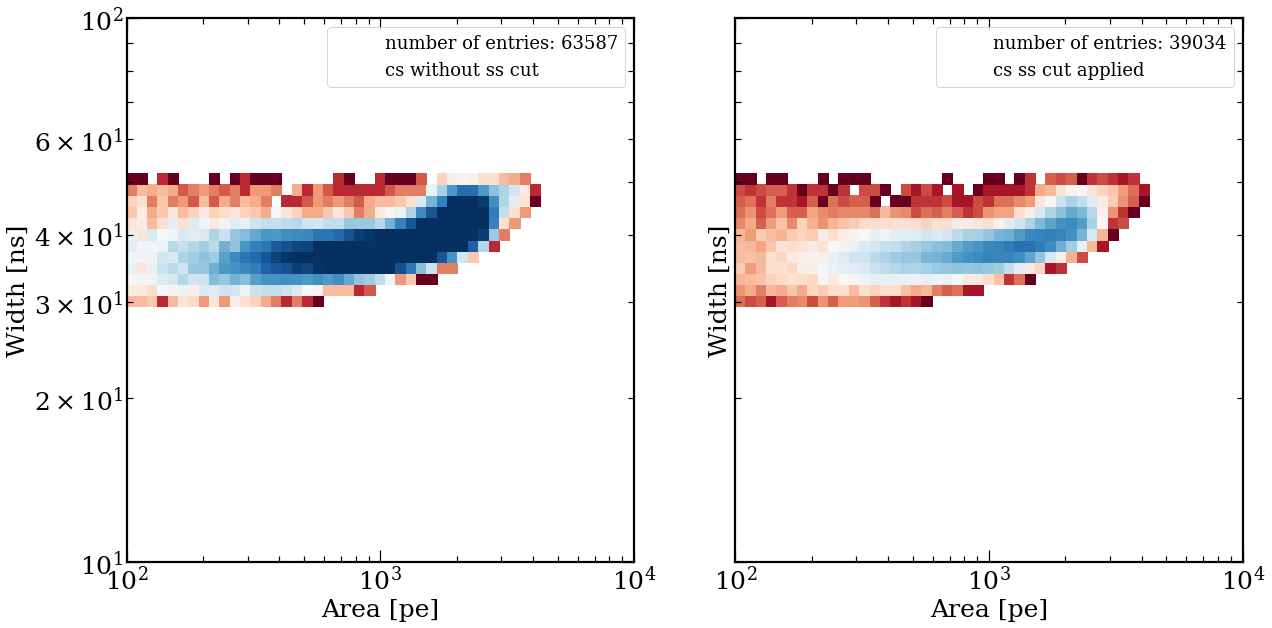

In [185]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(20,10),sharex=True, sharey=True)


plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20




axes1.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes1.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes1.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.yaxis.set_minor_locator(AutoMinorLocator(5))
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

axes2.tick_params(axis='both')

for axis in ['top','bottom','left','right']:
    axes2.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes2.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins_x = np.logspace(2,4,50)
bins_y = np.logspace(1,2,50)
histo_max= 2*10**3



counts_cs, _, _ = np.histogram2d(cs_s1_area_all_runs['00178'], cs_s1_width_all_runs['00178'], bins=(bins_x, bins_y))
counts_cs_scatter_cut, _, _ = np.histogram2d(cs_s1_area_corrected_all_runs['00178'], cs_s1_width_corrected_all_runs['00178'], bins=(bins_x, bins_y))

# counts_cs, _, _ = np.histogram2d(integral_all_runs['00178'], width_all_runs['00178'], bins=(bins_x, bins_y))
# counts_bk, _, _ = np.histogram2d(cut_integral_all_runs['00175'], cut_width_all_runs['00175'], bins=(bins_x, bins_y))


im = axes1.pcolormesh(bins_x, bins_y, counts_cs.T, norm=mpl.colors.LogNorm(), vmax=3e2, cmap = 'RdBu')
im = axes2.pcolormesh(bins_x, bins_y, counts_cs_scatter_cut.T, norm=mpl.colors.LogNorm(), vmax=3e3, cmap = 'RdBu')
##cb = plt.colorbar(im, ax=axes2, label='Counts')
cb.set_label('Counts',size=20)
#cb.ax.tick_params(labelsize=20) 
axes1.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_all_runs['00178'])))
axes1.plot([], [], ' ', label="cs without ss cut")
axes2.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])))
axes2.plot([], [], ' ', label="cs ss cut applied")
axes1.set_xscale('log')
axes1.set_yscale('log')
axes1.set_xlabel('Area [pe]')
axes1.set_ylabel('Width [ns]')
axes2.set_xscale('log')
axes2.set_yscale('log')
axes2.set_xlabel('Area [pe]')
axes2.set_ylabel('Width [ns]')
axes1.legend(loc=1, prop={'size': 18})
axes2.legend(loc=1, prop={'size': 18})
plt.show()


## Project corrected S1s on x-axis: log scale and normed per bin

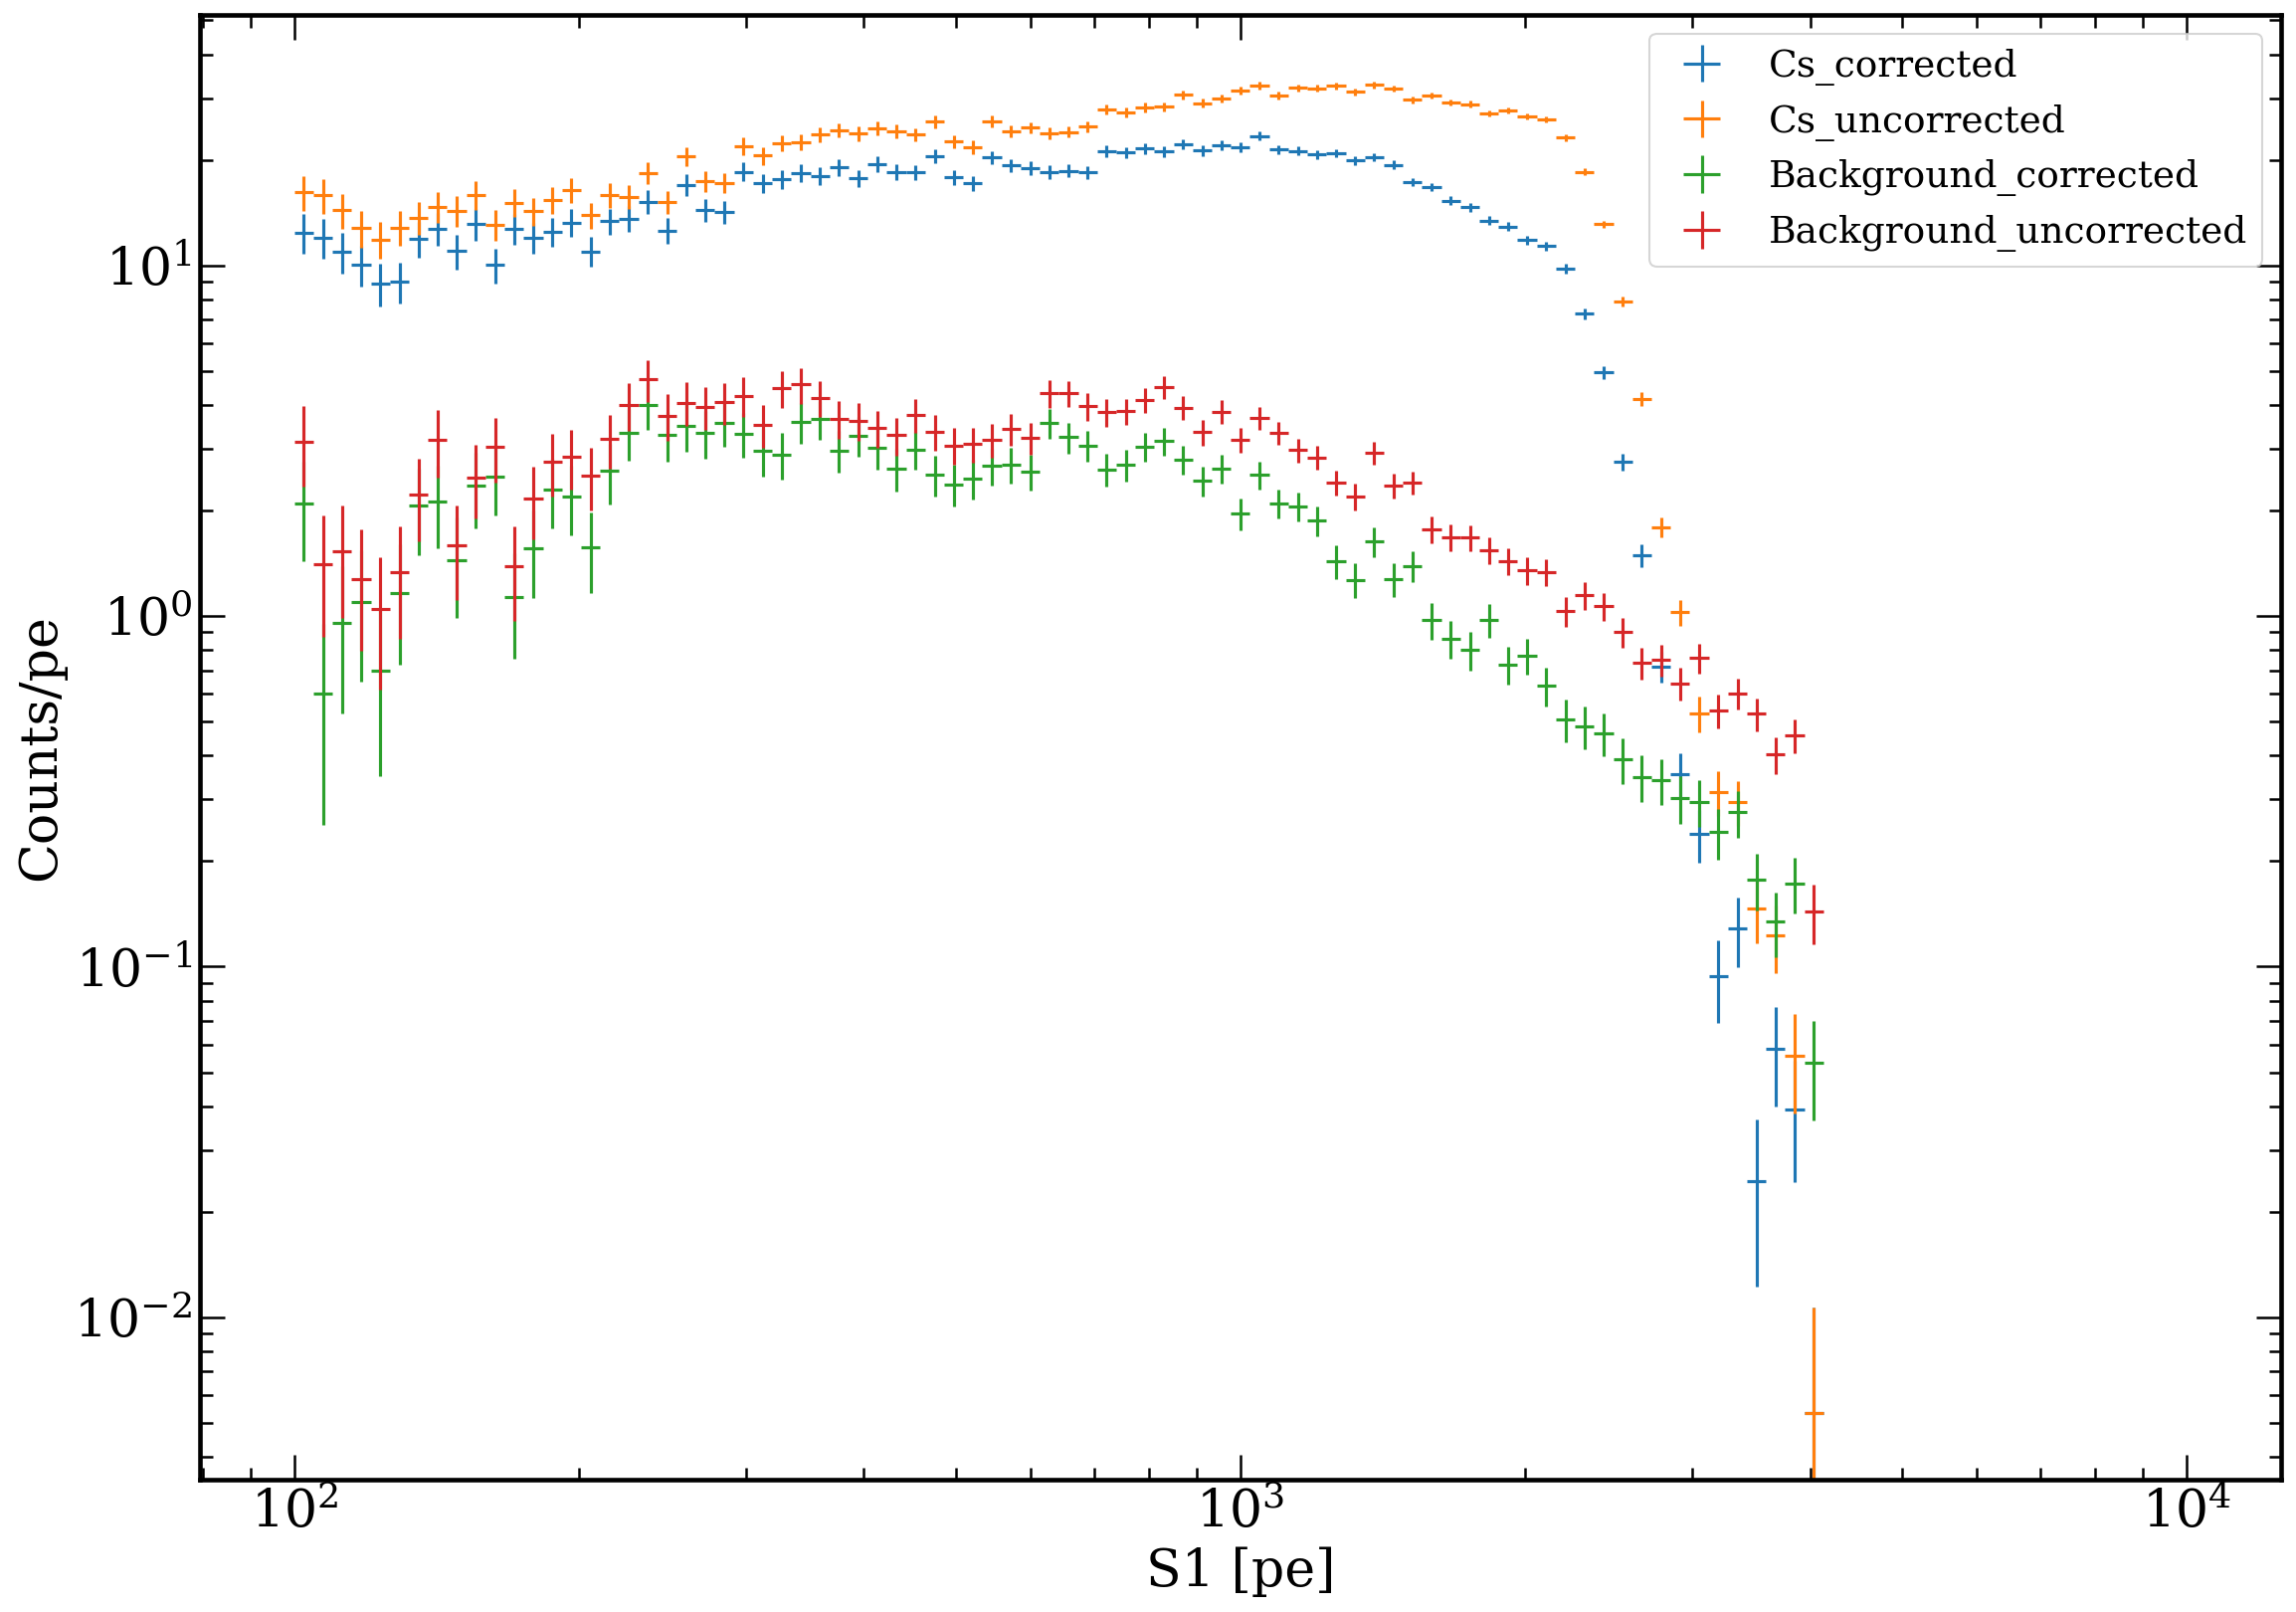

In [186]:



fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins = np.logspace(2,4,100)
bin_centers = 0.5*(bins[1:] + bins[:-1])
bin_fullwidths = (bins[1:] - bins[:-1])
# print(bins)
# print(bin_centers)
# print(bin_fullwidths)
cs_corrected, _ = np.histogram(cs_s1_area_corrected_all_runs['00178'], bins=bins)
plt.errorbar(bin_centers, cs_corrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(cs_corrected)/bin_fullwidths, capsize=0, linestyle='', label='Cs_corrected')

cs_uncorrected, _ = np.histogram(cs_s1_area_all_runs['00178'], bins=bins)
plt.errorbar(bin_centers, cs_uncorrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(cs_uncorrected)/bin_fullwidths, capsize=0, linestyle='', label='Cs_uncorrected')

background_corrected, _ = np.histogram(cs_s1_area_corrected_all_runs['00175'], bins=bins)
plt.errorbar(bin_centers, background_corrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(background_corrected)/bin_fullwidths, capsize=0, linestyle='', label='Background_corrected')

background_uncorrected, _ = np.histogram(cs_s1_area_all_runs['00175'], bins=bins)
plt.errorbar(bin_centers, background_uncorrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(background_uncorrected)/bin_fullwidths, capsize=0, linestyle='', label='Background_uncorrected')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Counts/pe')
plt.xlabel('S1 [pe]')
plt.legend(loc = 1,prop={'size': 18})
plt.show()

## Linear projection

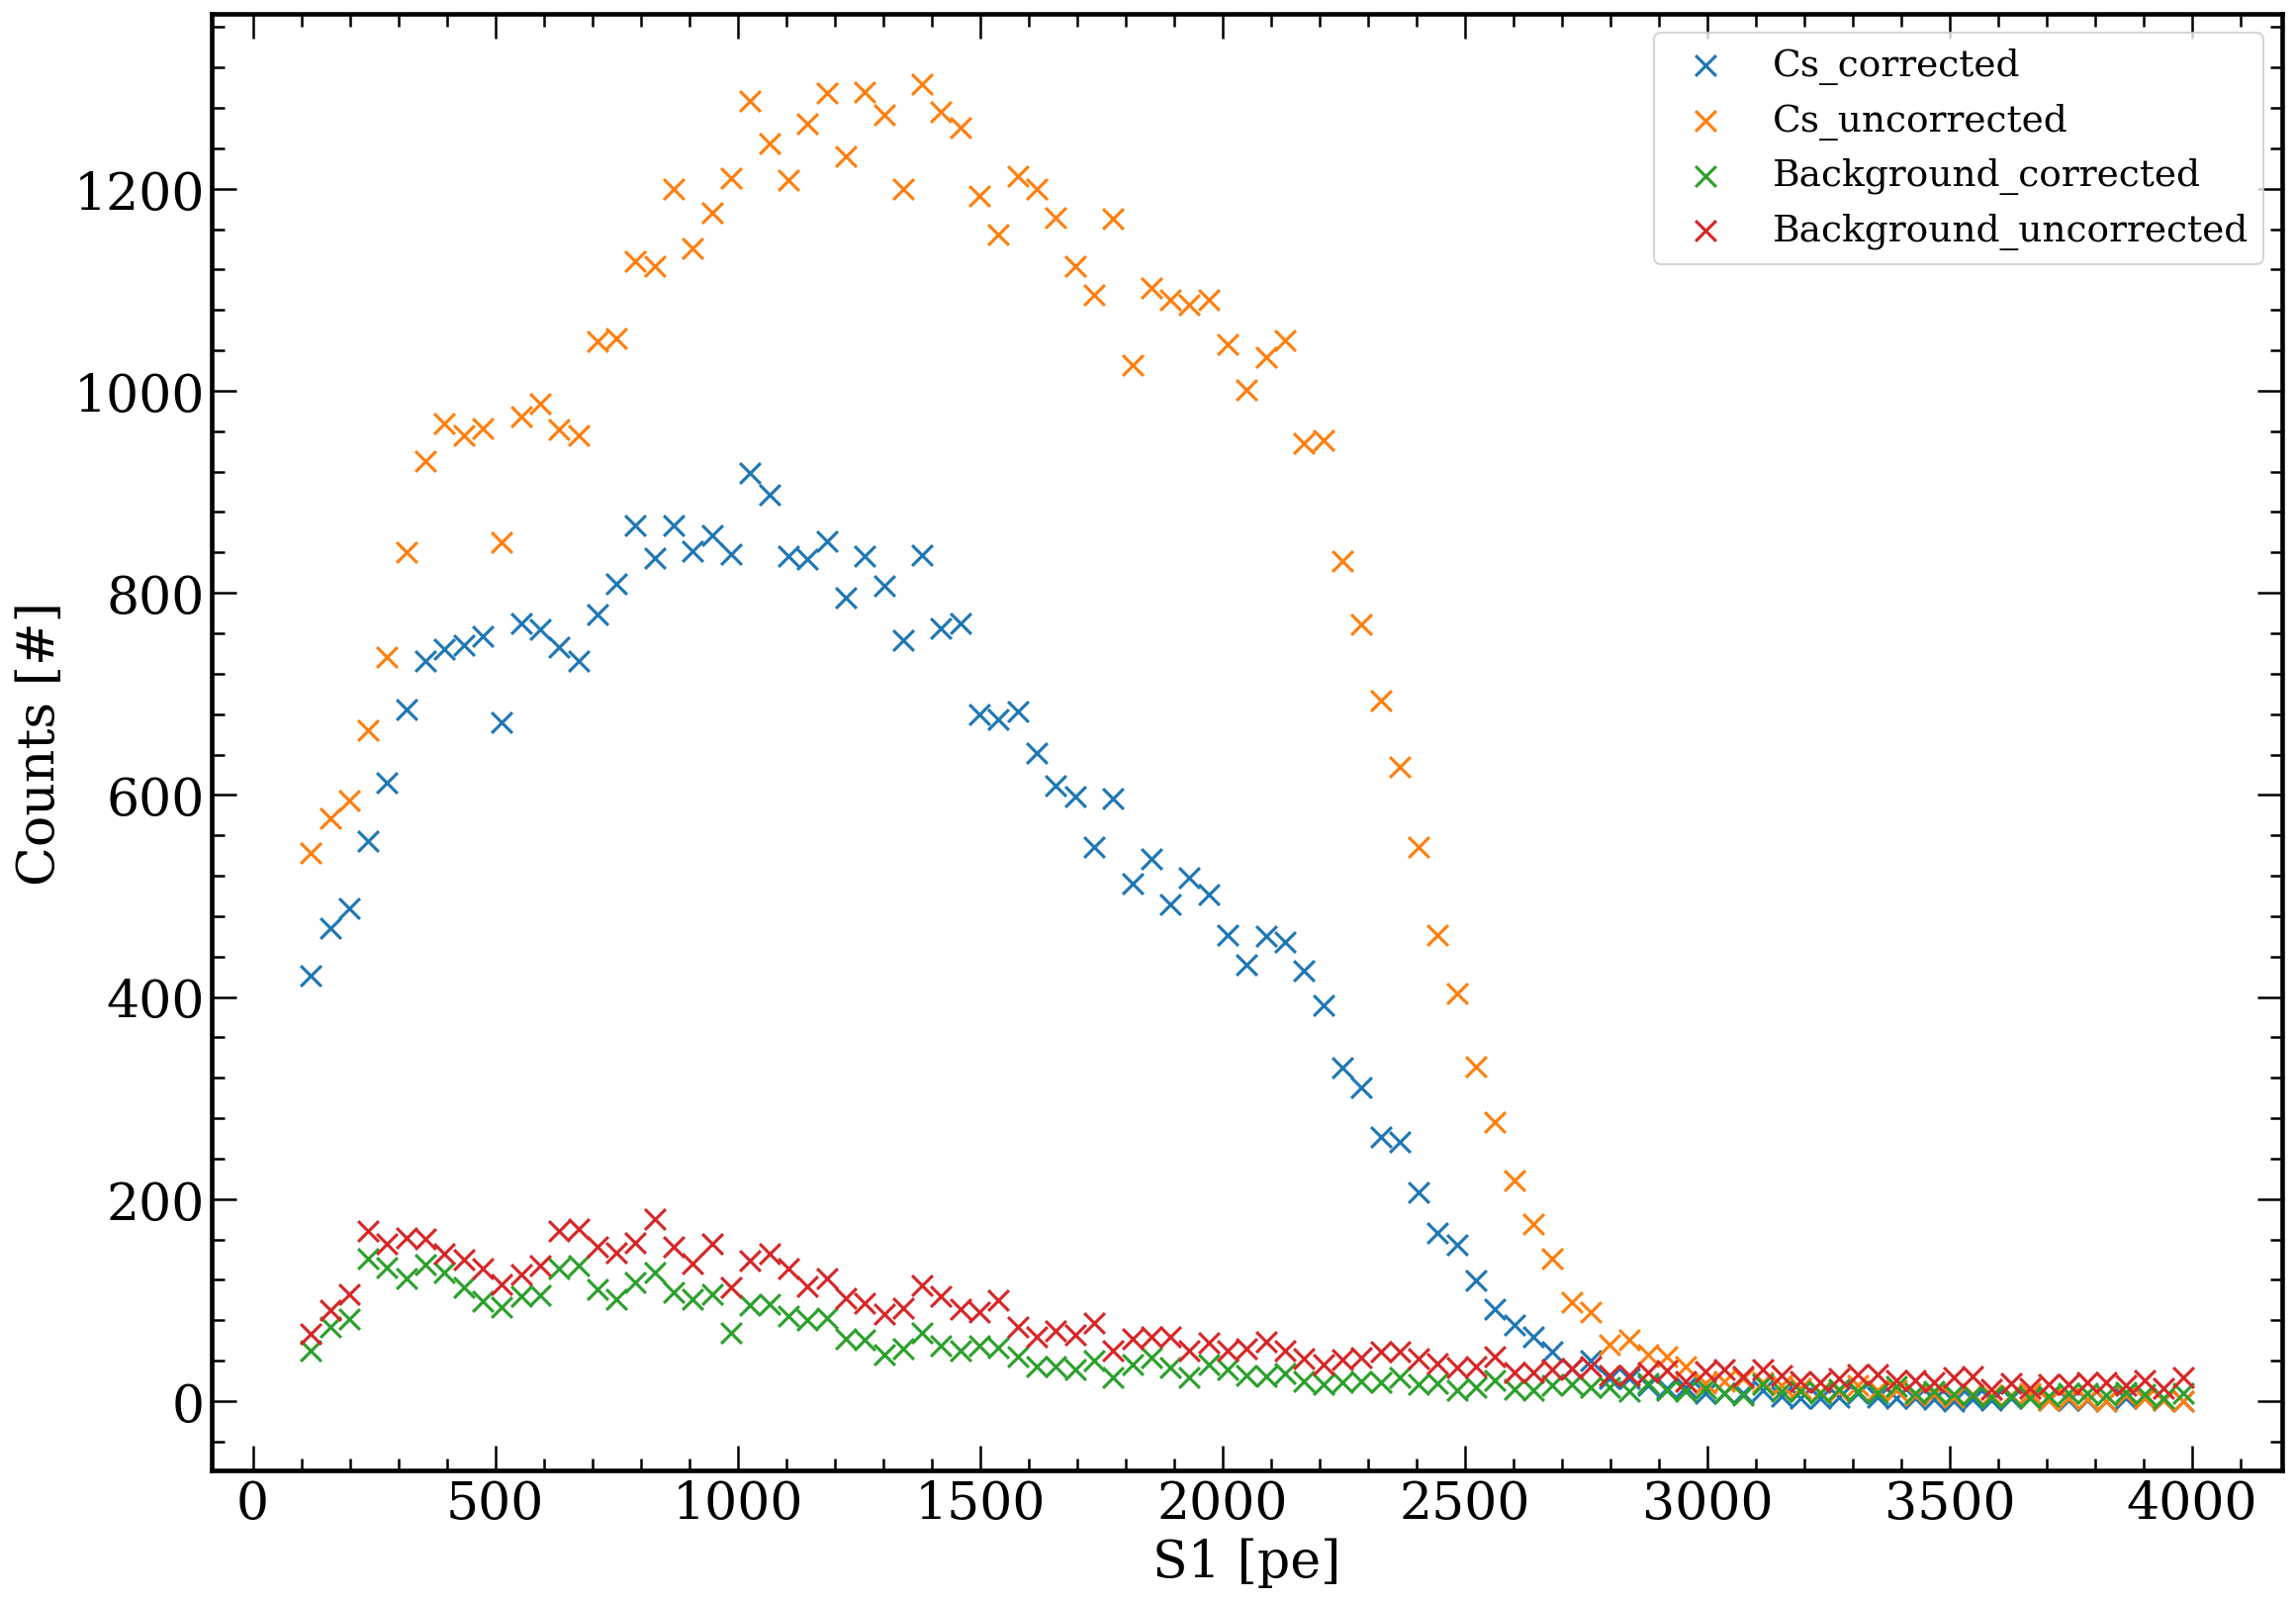

In [187]:
fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


Cs137_range = np.linspace(100, 4000,100)
Cs137_counts_corrected, Cs137_binEdges_corrected = np.histogram(cs_s1_area_corrected_all_runs['00178'], bins=Cs137_range)
Cs137_bincenters_corrected = 0.5 * (Cs137_binEdges_corrected[1:] + Cs137_binEdges_corrected[:-1])

Cs137_counts_uncorrected, Cs137_binEdges_uncorrected = np.histogram(cs_s1_area_all_runs['00178'], bins=Cs137_range)
Cs137_bincenters_uncorrected = 0.5 * (Cs137_binEdges_uncorrected[1:] + Cs137_binEdges_uncorrected[:-1])

Background_counts_uncorrected, Background_binEdges_uncorrected = np.histogram(cs_s1_area_all_runs['00175'], bins=Cs137_range)
Background_bincenters_uncorrected = 0.5 * (Background_binEdges_uncorrected[1:] + Background_binEdges_uncorrected[:-1])

Background_counts_corrected, Background_binEdges_corrected = np.histogram(cs_s1_area_corrected_all_runs['00175'], bins=Cs137_range)
Background_bincenters_corrected = 0.5 * (Background_binEdges_corrected[1:] + Background_binEdges_corrected[:-1])

axes.scatter(Cs137_bincenters_corrected, Cs137_counts_corrected , s=100,c = 'C0', marker = 'x', label = 'Cs_corrected')
axes.scatter(Cs137_bincenters_uncorrected, Cs137_counts_uncorrected , s=100,c = 'C1', marker = 'x', label = 'Cs_uncorrected')
axes.scatter(Background_bincenters_corrected, Background_counts_corrected , s=100,c = 'C2', marker = 'x', label = 'Background_corrected')
axes.scatter(Background_bincenters_uncorrected, Background_counts_uncorrected , s=100,c = 'C3', marker = 'x', label = 'Background_uncorrected')


#axes.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])))
# axes.set_xscale('log')
# axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('Counts [#]')
axes.legend(prop={'size': 18})
plt.show()

## S2 vs S1 

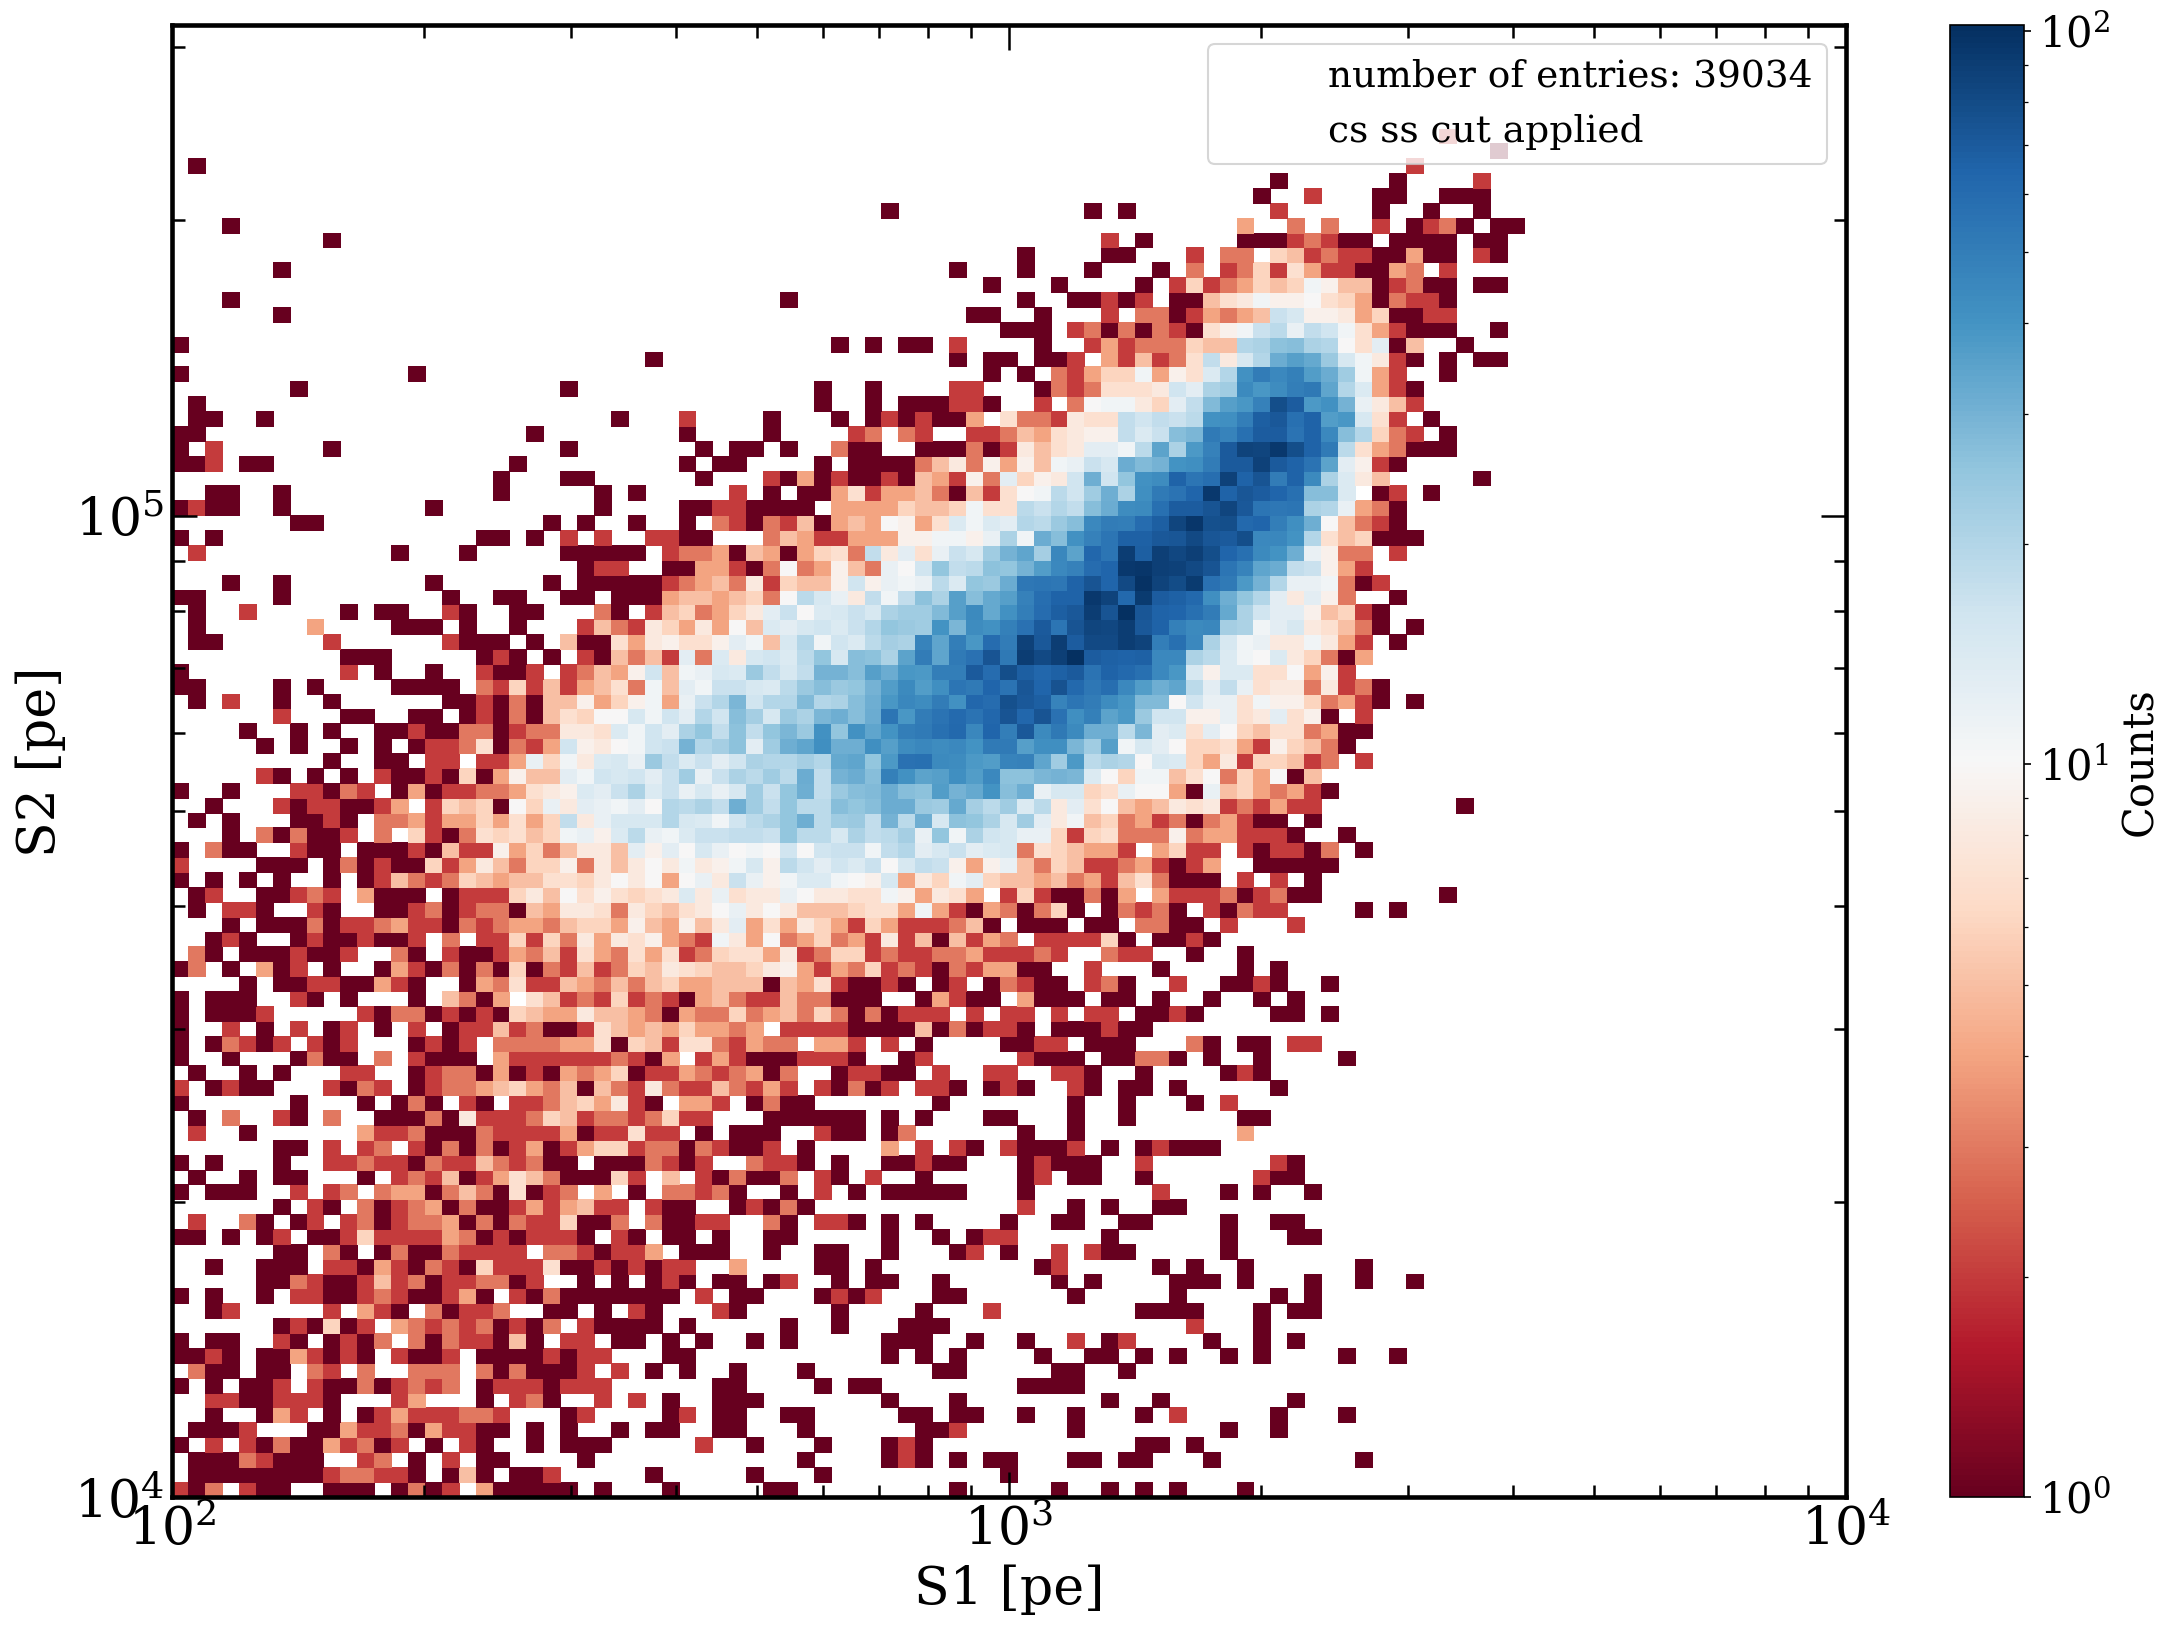

In [188]:



fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins_x = np.logspace(2,4,100)
bins_y = np.logspace(4,5.5,100)
histo_max= 2*10**3

S1_S2, _, _ = np.histogram2d(cs_s1_area_corrected_all_runs['00178'], cs_s2_area_corrected_all_runs['00178'], bins=(bins_x, bins_y))



im = axes.pcolormesh(bins_x, bins_y, S1_S2.T, norm=mpl.colors.LogNorm(), cmap = 'RdBu')
axes.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])))
axes.plot([], [], ' ', label="cs ss cut applied")
cb = plt.colorbar(im, ax=axes, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20) 
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('S2 [pe]')
plt.legend(loc = 1, prop={'size':18})

plt.show()

# sums up the distribution for S1 and S2 region with/without ss cut

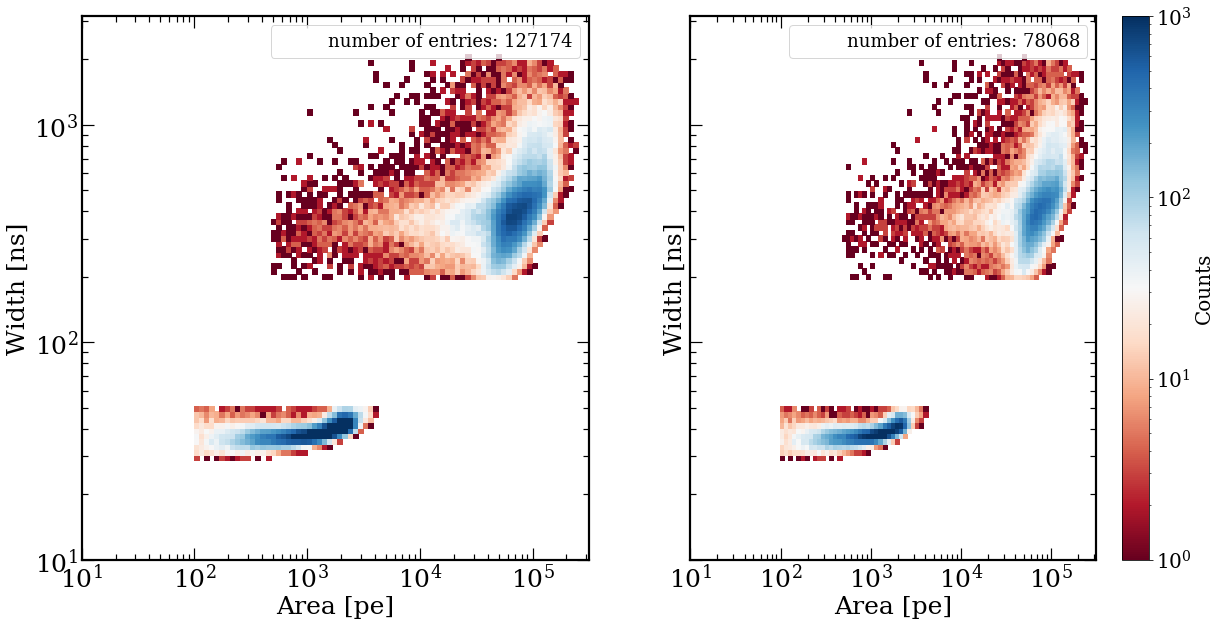

In [189]:
fig, (axes1,axes2) = plt.subplots(1,2,figsize=(20,10),sharex=True, sharey=True)


plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20




axes1.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes1.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes1.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.yaxis.set_minor_locator(AutoMinorLocator(5))
axes1.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes1.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

axes2.tick_params(axis='both')

for axis in ['top','bottom','left','right']:
    axes2.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes2.xaxis.set_minor_locator(AutoMinorLocator(5)) 
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
axes2.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes2.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins_x = np.logspace(1,5.5,100)
bins_y = np.logspace(1,3.5,100)
histo_max= 2*10**3



counts_cs_S1, _, _ = np.histogram2d(cs_s1_area_all_runs['00178'], cs_s1_width_all_runs['00178'], bins=(bins_x, bins_y))
counts_cs_S1_scatter_cut, _, _ = np.histogram2d(cs_s1_area_corrected_all_runs['00178'], cs_s1_width_corrected_all_runs['00178'], bins=(bins_x, bins_y))

counts_cs_S2, _, _ = np.histogram2d(cs_s2_area_all_runs['00178'], cs_s2_width_all_runs['00178'], bins=(bins_x, bins_y))
counts_cs_S2_scatter_cut, _, _ = np.histogram2d(cs_s2_area_corrected_all_runs['00178'], cs_s2_width_corrected_all_runs['00178'], bins=(bins_x, bins_y))

# counts_cs, _, _ = np.histogram2d(integral_all_runs['00178'], width_all_runs['00178'], bins=(bins_x, bins_y))
# counts_bk, _, _ = np.histogram2d(cut_integral_all_runs['00175'], cut_width_all_runs['00175'], bins=(bins_x, bins_y))


im = axes1.pcolormesh(bins_x, bins_y, counts_cs_S1.T, norm=mpl.colors.LogNorm(), vmax=1e3, cmap = 'RdBu')
im = axes2.pcolormesh(bins_x, bins_y, counts_cs_S1_scatter_cut.T, norm=mpl.colors.LogNorm(), vmax=1e3, cmap = 'RdBu')
im = axes1.pcolormesh(bins_x, bins_y, counts_cs_S2.T, norm=mpl.colors.LogNorm(), vmax=1e3, cmap = 'RdBu')
im = axes2.pcolormesh(bins_x, bins_y, counts_cs_S2_scatter_cut.T, norm=mpl.colors.LogNorm(), vmax=1e3, cmap = 'RdBu')
cb = plt.colorbar(im, ax=axes2, label='Counts')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20) 

axes1.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_all_runs['00178'])+len(cs_s2_area_all_runs['00178'])))
axes2.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])+len(cs_s2_area_corrected_all_runs['00178'])))
axes1.set_xscale('log')
axes1.set_yscale('log')
axes1.set_xlabel('Area [pe]')
axes1.set_ylabel('Width [ns]')
axes2.set_xscale('log')
axes2.set_yscale('log')
axes2.set_xlabel('Area [pe]')
axes2.set_ylabel('Width [ns]')
axes1.legend(loc=1, prop={'size':18})
axes2.legend(loc=1, prop={'size':18})

plt.show()


## For PMT 7 only

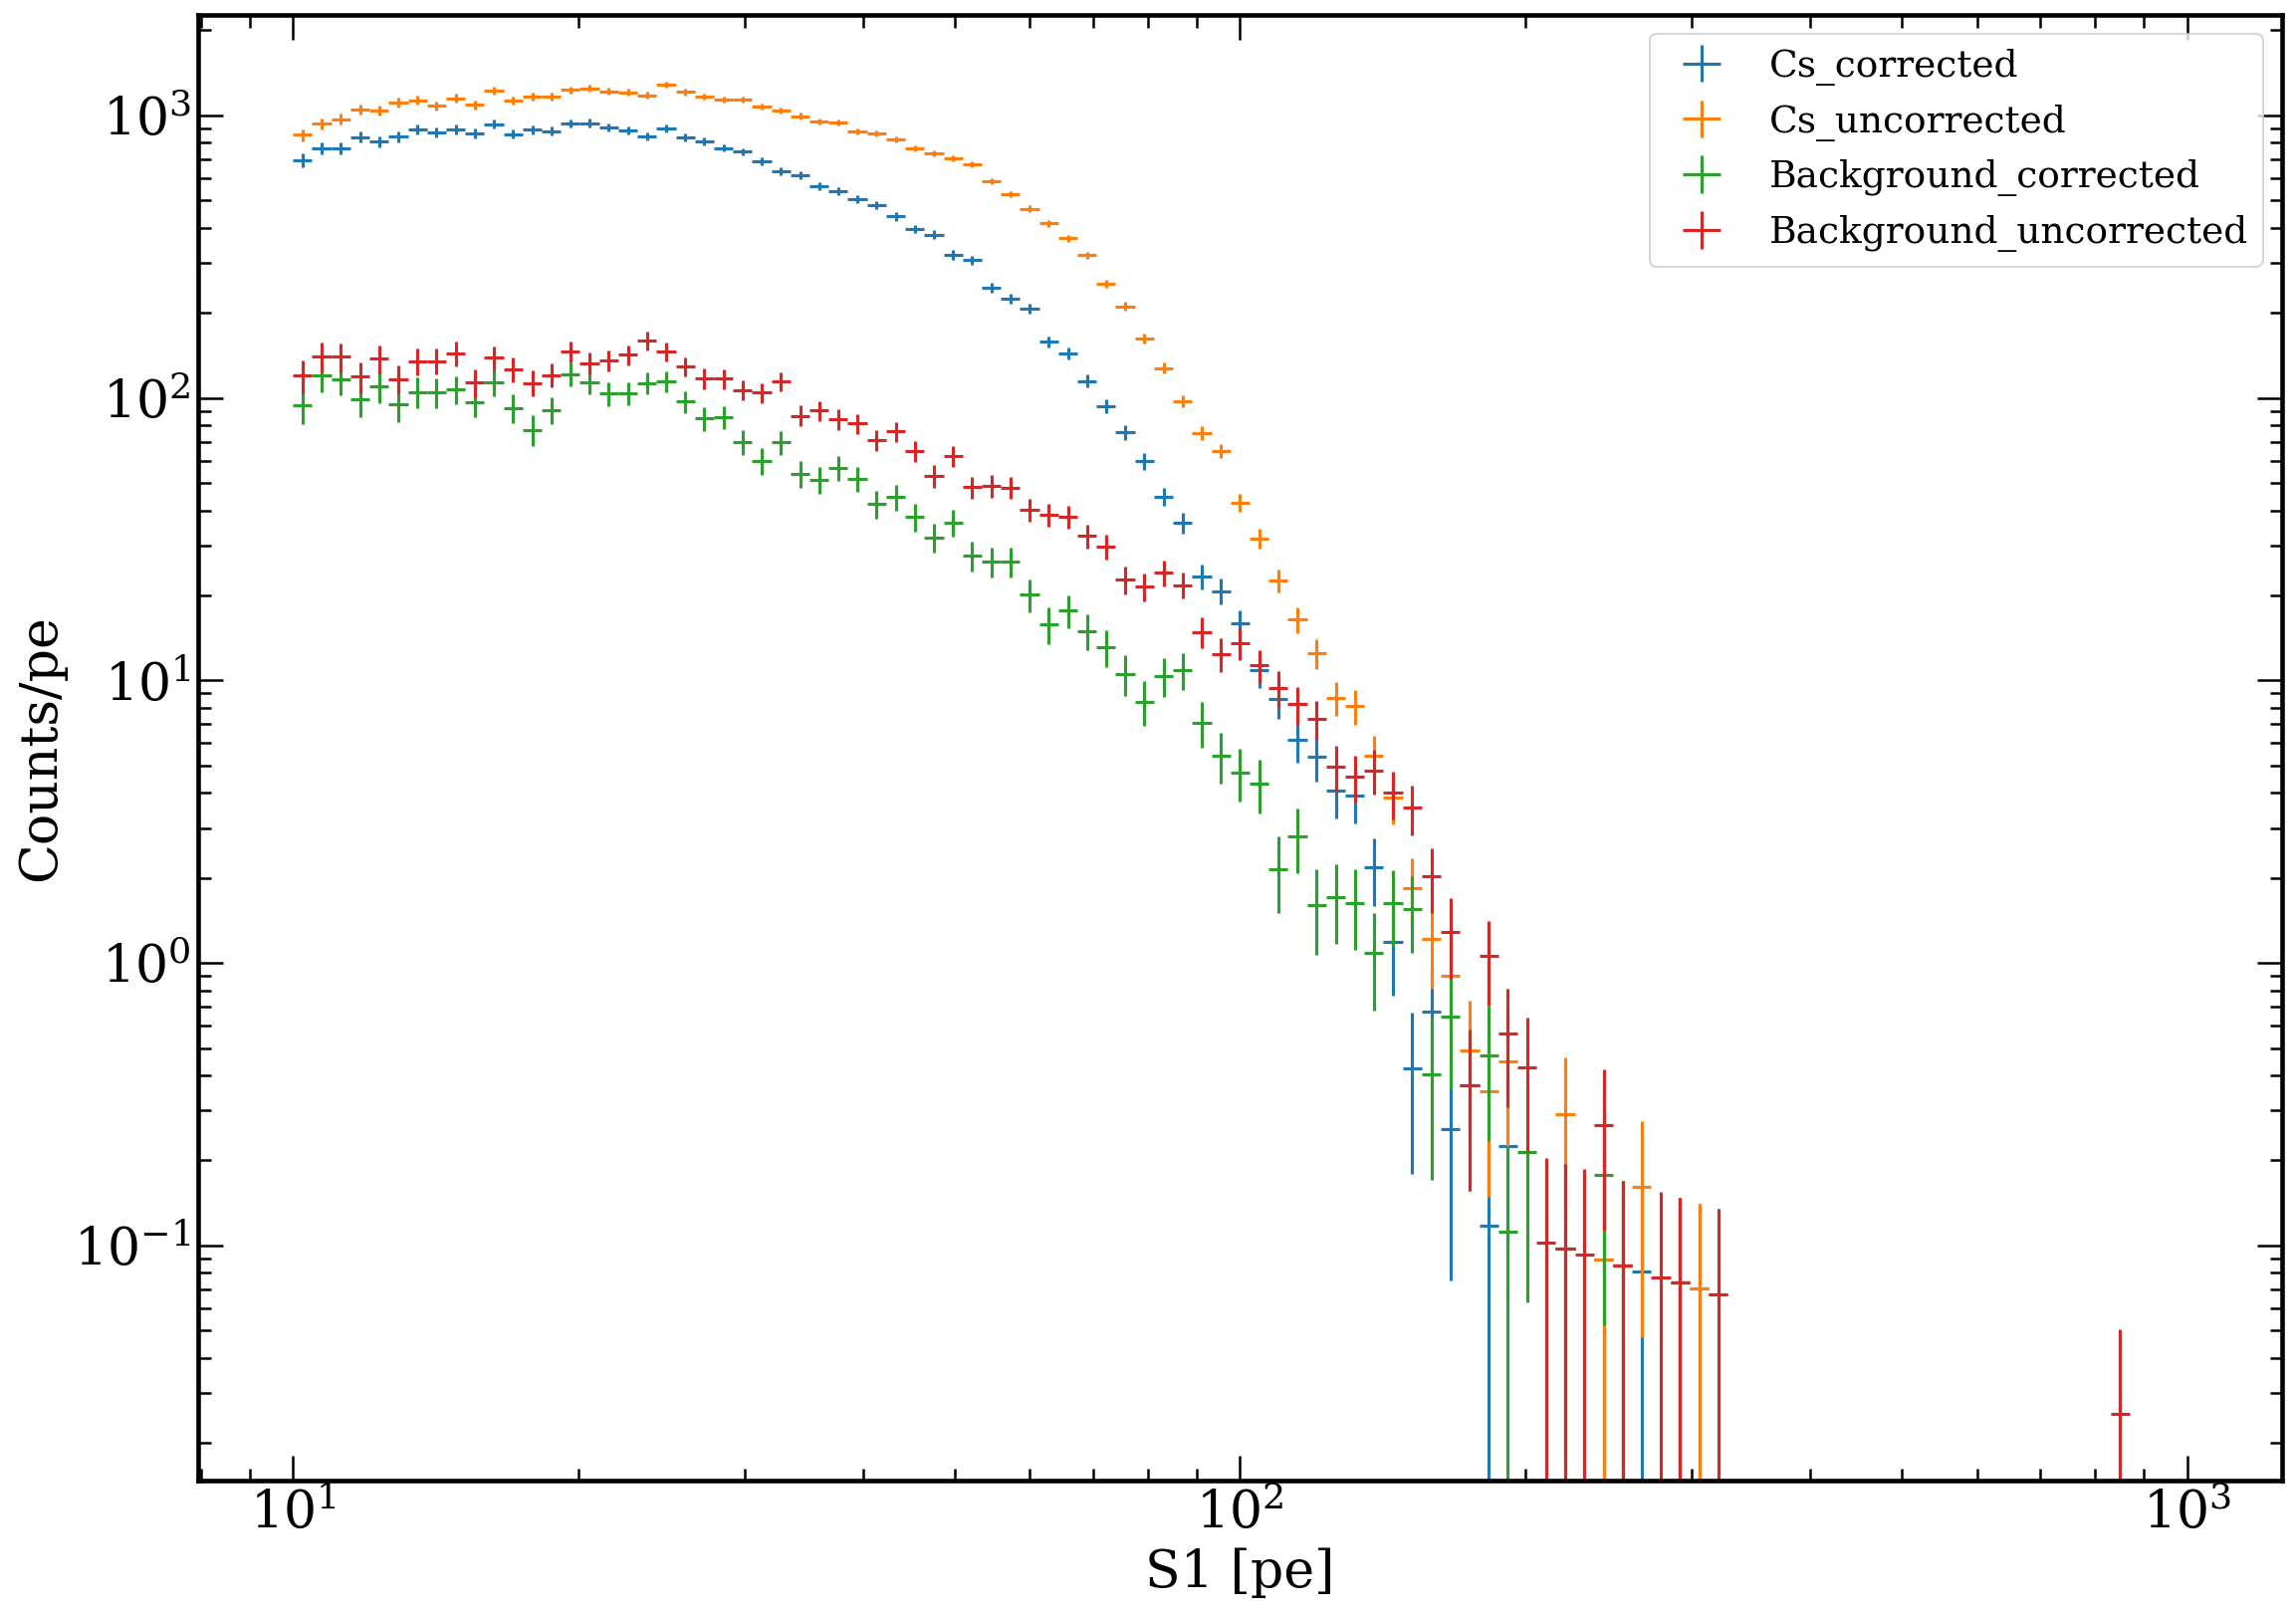

In [190]:



fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


bins = np.logspace(1,3,100)
bin_centers = 0.5*(bins[1:] + bins[:-1])
bin_fullwidths = (bins[1:] - bins[:-1])
# print(bins)
# print(bin_centers)
# print(bin_fullwidths)
cs_corrected, _ = np.histogram(PMTs_S1_corrected_all_runs['00178'][6], bins=bins)
plt.errorbar(bin_centers, cs_corrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(cs_corrected)/bin_fullwidths, capsize=0, linestyle='', label='Cs_corrected')

cs_uncorrected, _ = np.histogram(PMTs_S1_all_runs['00178'][6], bins=bins)
plt.errorbar(bin_centers, cs_uncorrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(cs_uncorrected)/bin_fullwidths, capsize=0, linestyle='', label='Cs_uncorrected')

background_corrected, _ = np.histogram(PMTs_S1_corrected_all_runs['00175'][6], bins=bins)
plt.errorbar(bin_centers, background_corrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(background_corrected)/bin_fullwidths, capsize=0, linestyle='', label='Background_corrected')

background_uncorrected, _ = np.histogram(PMTs_S1_all_runs['00175'][6], bins=bins)
plt.errorbar(bin_centers, background_uncorrected/bin_fullwidths, xerr=0.5*bin_fullwidths, yerr=np.sqrt(background_uncorrected)/bin_fullwidths, capsize=0, linestyle='', label='Background_uncorrected')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Counts/pe')
plt.xlabel('S1 [pe]')
plt.legend(loc = 1,prop={'size': 18})
plt.show()

# For PMT 7 only (linear scale)

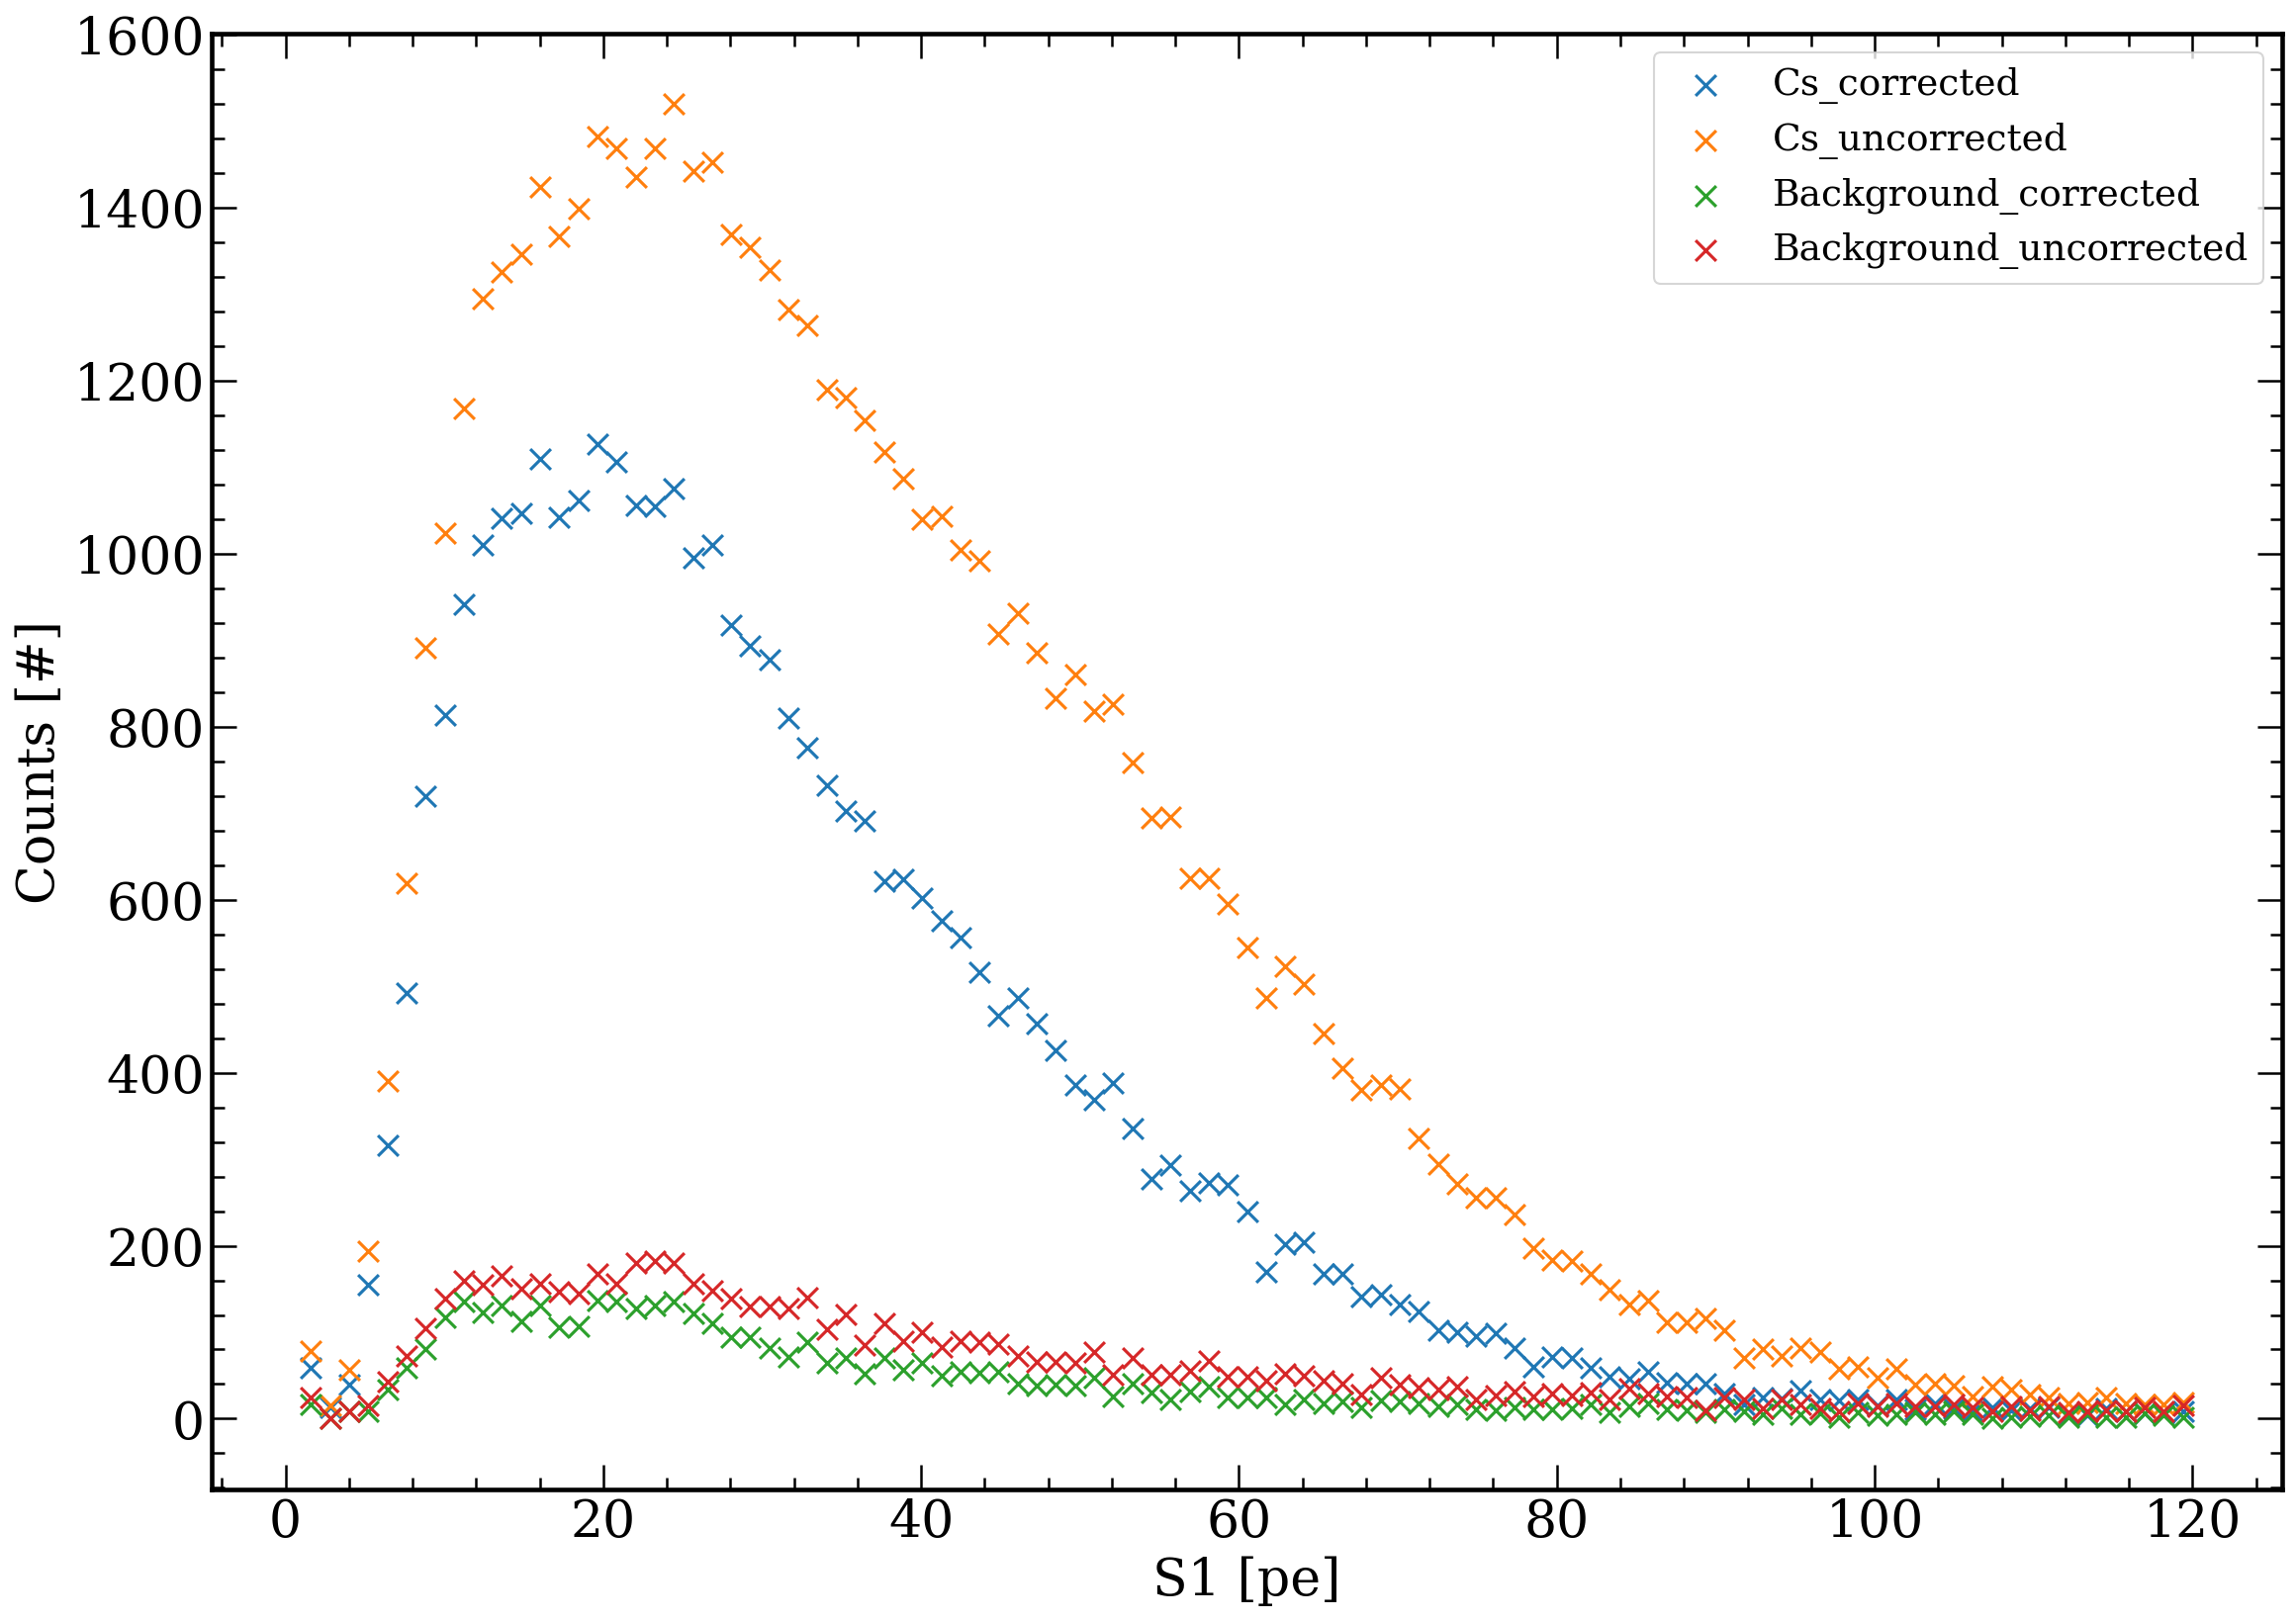

In [191]:
fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


Cs137_range = np.linspace(1, 120,100)
Cs137_counts_corrected, Cs137_binEdges_corrected = np.histogram(PMTs_S1_corrected_all_runs['00178'][6], bins=Cs137_range)
Cs137_bincenters_corrected = 0.5 * (Cs137_binEdges_corrected[1:] + Cs137_binEdges_corrected[:-1])

Cs137_counts_uncorrected, Cs137_binEdges_uncorrected = np.histogram(PMTs_S1_all_runs['00178'][6], bins=Cs137_range)
Cs137_bincenters_uncorrected = 0.5 * (Cs137_binEdges_uncorrected[1:] + Cs137_binEdges_uncorrected[:-1])

Background_counts_uncorrected, Background_binEdges_uncorrected = np.histogram(PMTs_S1_all_runs['00175'][6], bins=Cs137_range)
Background_bincenters_uncorrected = 0.5 * (Background_binEdges_uncorrected[1:] + Background_binEdges_uncorrected[:-1])

Background_counts_corrected, Background_binEdges_corrected = np.histogram(PMTs_S1_corrected_all_runs['00175'][6], bins=Cs137_range)
Background_bincenters_corrected = 0.5 * (Background_binEdges_corrected[1:] + Background_binEdges_corrected[:-1])

axes.scatter(Cs137_bincenters_corrected, Cs137_counts_corrected , s=100,c = 'C0', marker = 'x', label = 'Cs_corrected')
axes.scatter(Cs137_bincenters_uncorrected, Cs137_counts_uncorrected , s=100,c = 'C1', marker = 'x', label = 'Cs_uncorrected')
axes.scatter(Background_bincenters_corrected, Background_counts_corrected , s=100,c = 'C2', marker = 'x', label = 'Background_corrected')
axes.scatter(Background_bincenters_uncorrected, Background_counts_uncorrected , s=100,c = 'C3', marker = 'x', label = 'Background_uncorrected')


#axes.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])))
# axes.set_xscale('log')
# axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('Counts [#]')
axes.legend(prop={'size': 18})
plt.show()

## Sum of top PMT array

In [192]:
sum_s1_area_corrected = [a + b +c+d+e+f+g for a,b,c,d,e,f,g in zip(PMTs_S1_corrected_all_runs['00178'][0], PMTs_S1_corrected_all_runs['00178'][1],PMTs_S1_corrected_all_runs['00178'][2],PMTs_S1_corrected_all_runs['00178'][3],PMTs_S1_corrected_all_runs['00178'][4],PMTs_S1_corrected_all_runs['00178'][5],PMTs_S1_corrected_all_runs['00178'][6])]
sum_s1_area_uncorrected = [a + b +c+d+e+f+g for a,b,c,d,e,f,g in zip(PMTs_S1_all_runs['00178'][0], PMTs_S1_all_runs['00178'][1],PMTs_S1_all_runs['00178'][2],PMTs_S1_all_runs['00178'][3],PMTs_S1_all_runs['00178'][4],PMTs_S1_all_runs['00178'][5],PMTs_S1_all_runs['00178'][6])]
sum_s1_area_bkg_corrected = [a + b +c+d+e+f+g for a,b,c,d,e,f,g in zip(PMTs_S1_corrected_all_runs['00175'][0], PMTs_S1_corrected_all_runs['00175'][1],PMTs_S1_corrected_all_runs['00175'][2],PMTs_S1_corrected_all_runs['00175'][3],PMTs_S1_corrected_all_runs['00175'][4],PMTs_S1_corrected_all_runs['00175'][5],PMTs_S1_corrected_all_runs['00175'][6])]
sum_s1_area_bkg_uncorrected = [a + b +c+d+e+f+g for a,b,c,d,e,f,g in zip(PMTs_S1_all_runs['00175'][0], PMTs_S1_all_runs['00175'][1],PMTs_S1_all_runs['00175'][2],PMTs_S1_all_runs['00175'][3],PMTs_S1_all_runs['00175'][4],PMTs_S1_all_runs['00175'][5],PMTs_S1_all_runs['00175'][6])]
#sum_s1_area_corrected = [a + b +c+d+e+f+g for a,b,c,d,e,f,g in zip(PMTs_S1_corrected_all_runs['00175'][0], PMTs_S1_corrected_all_runs['00175'][1],PMTs_S1_corrected_all_runs['00175'][2],PMTs_S1_corrected_all_runs['00175'][3],PMTs_S1_corrected_all_runs['00175'][4],PMTs_S1_corrected_all_runs['00175'][5],PMTs_S1_corrected_all_runs['00175'][6])]


# print(PMTs_S1_corrected_all_runs['00178'][0][:2])
# print(PMTs_S1_corrected_all_runs['00178'][1][:2])
# print(PMTs_S1_corrected_all_runs['00178'][2][:2])
# print(PMTs_S1_corrected_all_runs['00178'][3][:2])
# print(PMTs_S1_corrected_all_runs['00178'][4][:2])
# print(PMTs_S1_corrected_all_runs['00178'][5][:2])
# print(PMTs_S1_corrected_all_runs['00178'][6][:2])
# print(sum_s1_area_corrected[:2])
print(len(sum_s1_area_corrected))
print(len(sum_s1_area_uncorrected))

37723
61148


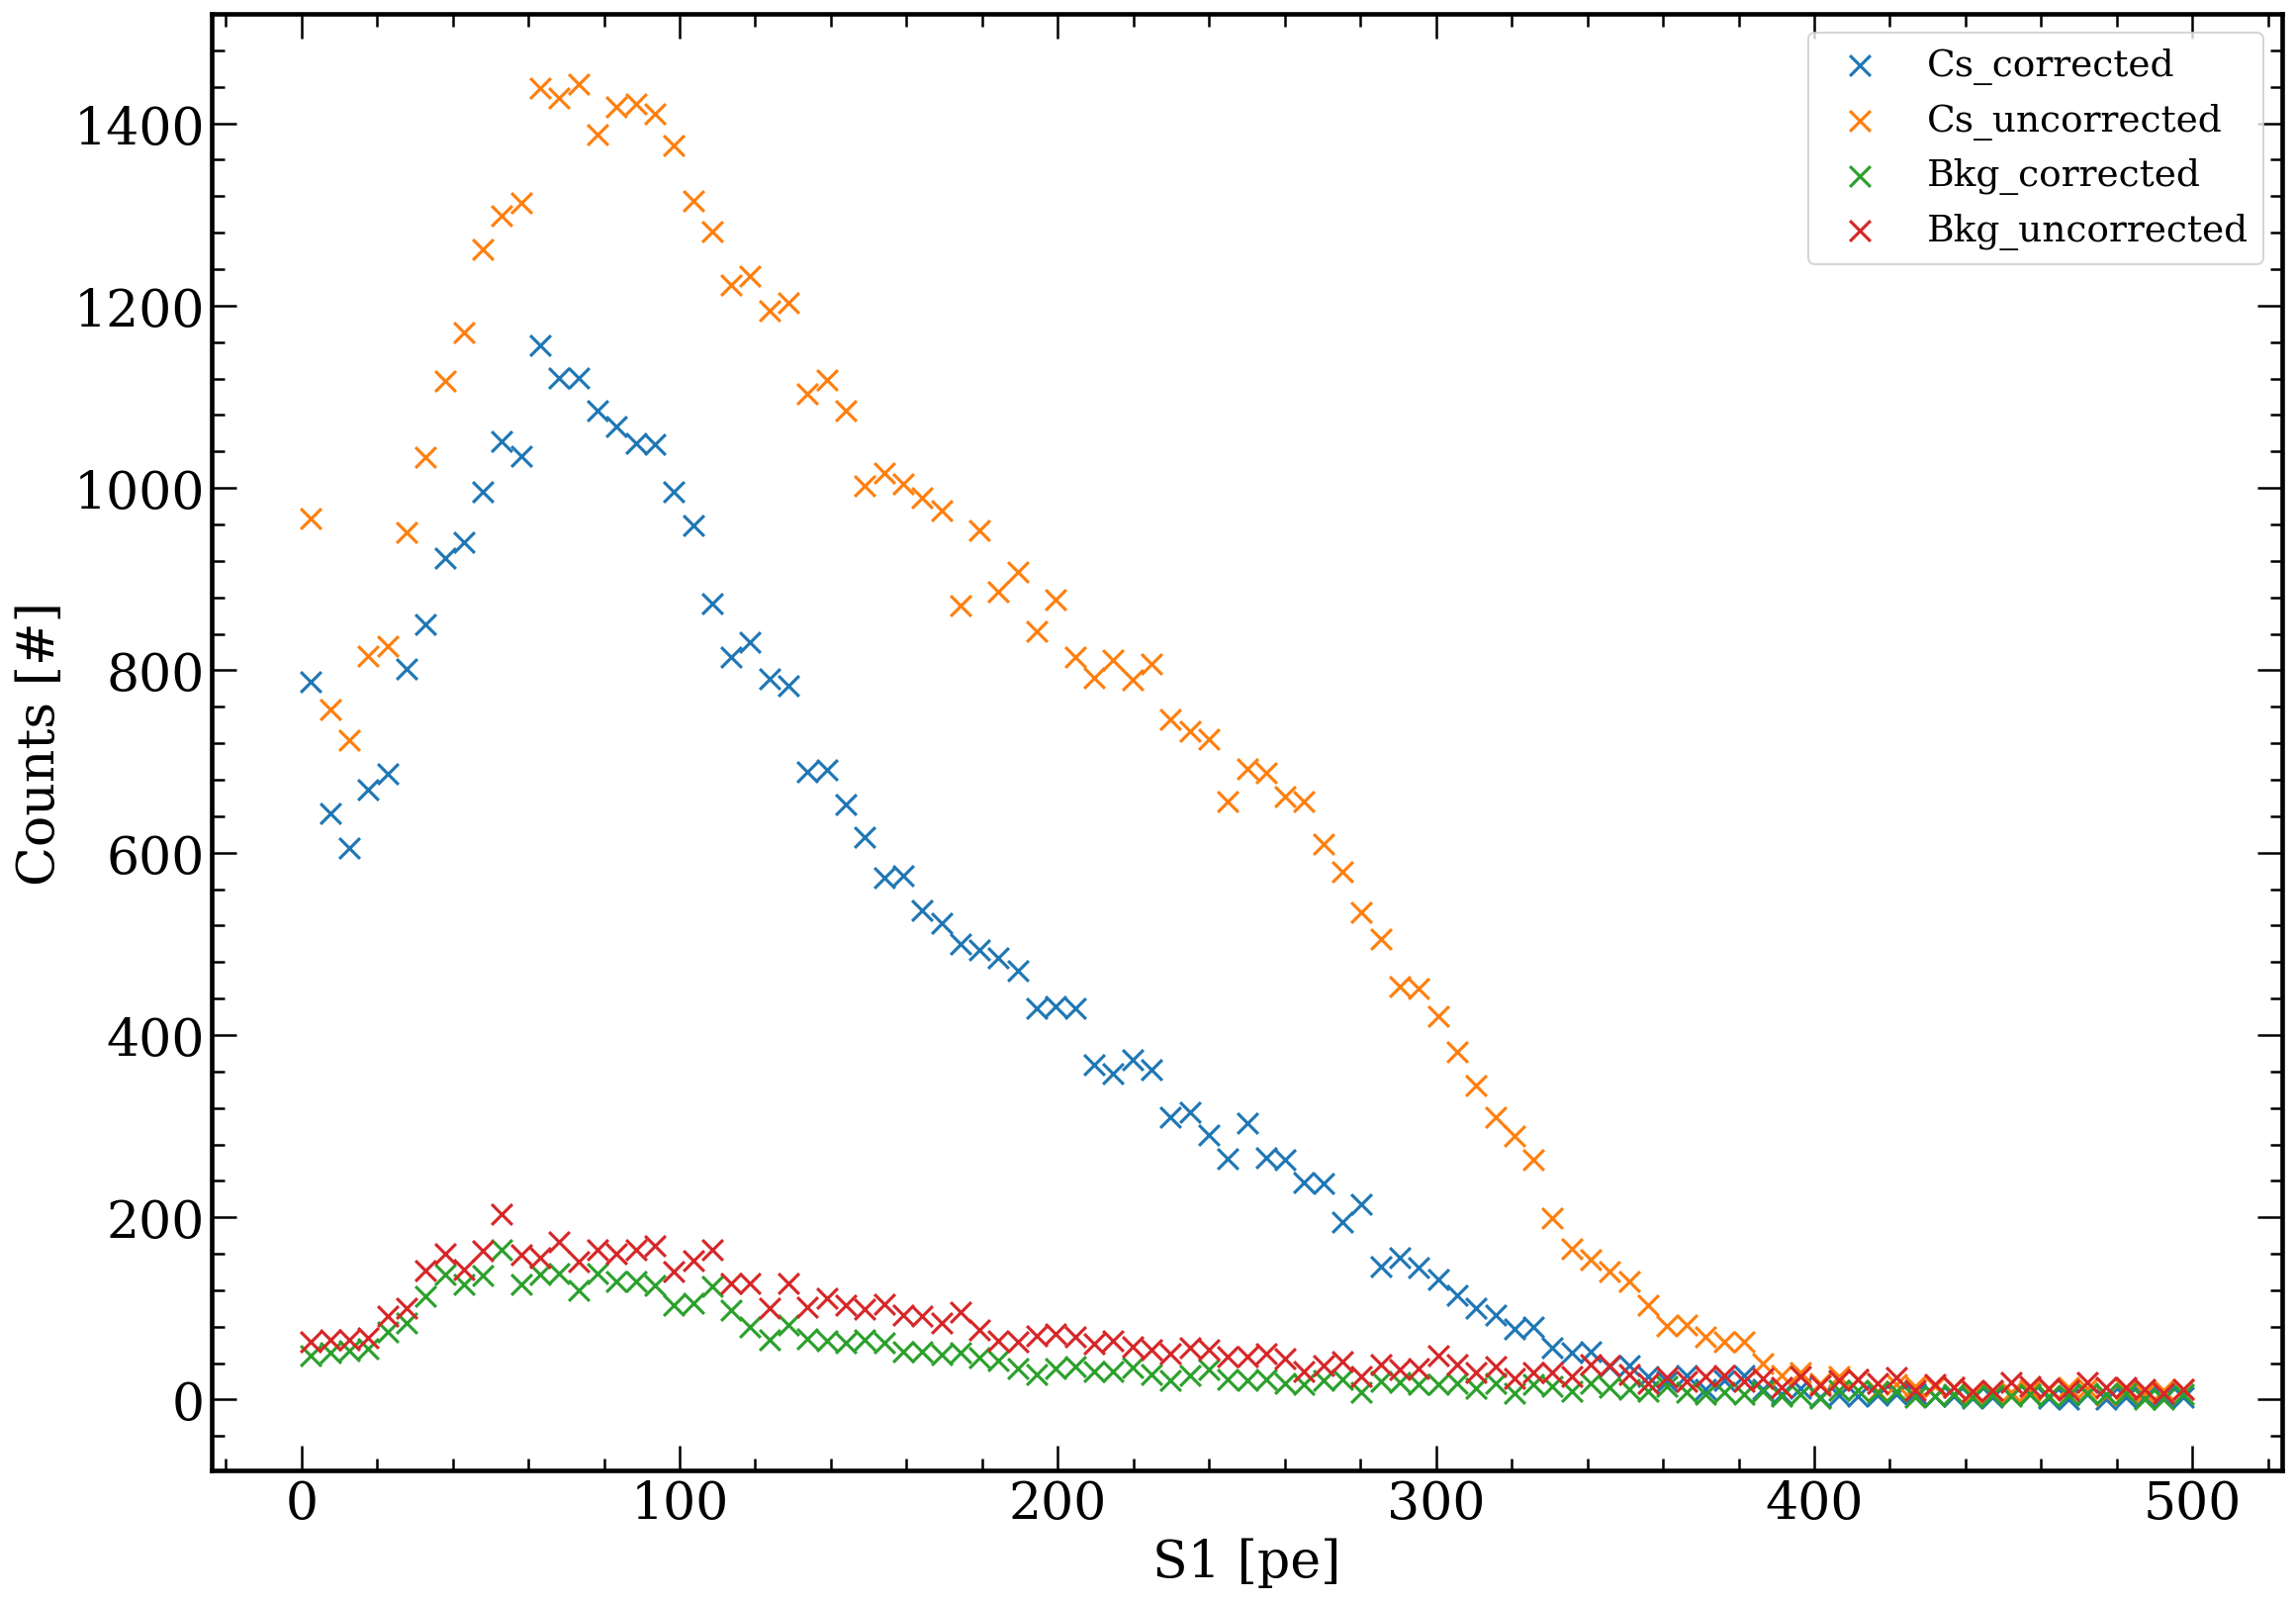

In [193]:
fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


Sum_range = np.linspace(0, 500,100)

Sum_counts_corrected_all, Sum_binEdges_corrected = np.histogram(sum_s1_area_corrected, bins=Sum_range)
Sum_bincenters_corrected = 0.5 * (Sum_binEdges_corrected[1:] + Sum_binEdges_corrected[:-1])

Sum_counts_uncorrected_all, Sum_binEdges_uncorrected = np.histogram(sum_s1_area_uncorrected, bins=Sum_range)
Sum_bincenters_uncorrected = 0.5 * (Sum_binEdges_uncorrected[1:] + Sum_binEdges_uncorrected[:-1])




Sum_counts_bkg_corrected_all, Sum_binEdges_bkg_corrected = np.histogram(sum_s1_area_bkg_corrected, bins=Sum_range)
Sum_bincenters_bkg_corrected = 0.5 * (Sum_binEdges_bkg_corrected[1:] + Sum_binEdges_bkg_corrected[:-1])

Sum_counts_bkg_uncorrected_all, Sum_binEdges_bkg_uncorrected = np.histogram(sum_s1_area_bkg_uncorrected, bins=Sum_range)
Sum_bincenters_bkg_uncorrected = 0.5 * (Sum_binEdges_bkg_uncorrected[1:] + Sum_binEdges_bkg_uncorrected[:-1])


axes.scatter(Sum_bincenters_corrected, Sum_counts_corrected_all , s=100,c = 'C0', marker = 'x', label = 'Cs_corrected')
axes.scatter(Sum_bincenters_uncorrected, Sum_counts_uncorrected_all , s=100,c = 'C1', marker = 'x', label = 'Cs_uncorrected')
axes.scatter(Sum_bincenters_bkg_corrected, Sum_counts_bkg_corrected_all , s=100,c = 'C2', marker = 'x', label = 'Bkg_corrected')
axes.scatter(Sum_bincenters_bkg_uncorrected, Sum_counts_bkg_uncorrected_all , s=100,c = 'C3', marker = 'x', label = 'Bkg_uncorrected')


#axes.plot([], [], ' ', label="number of entries: "+str(len(cs_s1_area_corrected_all_runs['00178'])))
# axes.set_xscale('log')
# axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('Counts [#]')
axes.legend(prop={'size': 18})
plt.show()

# Compare opposite side PMTs

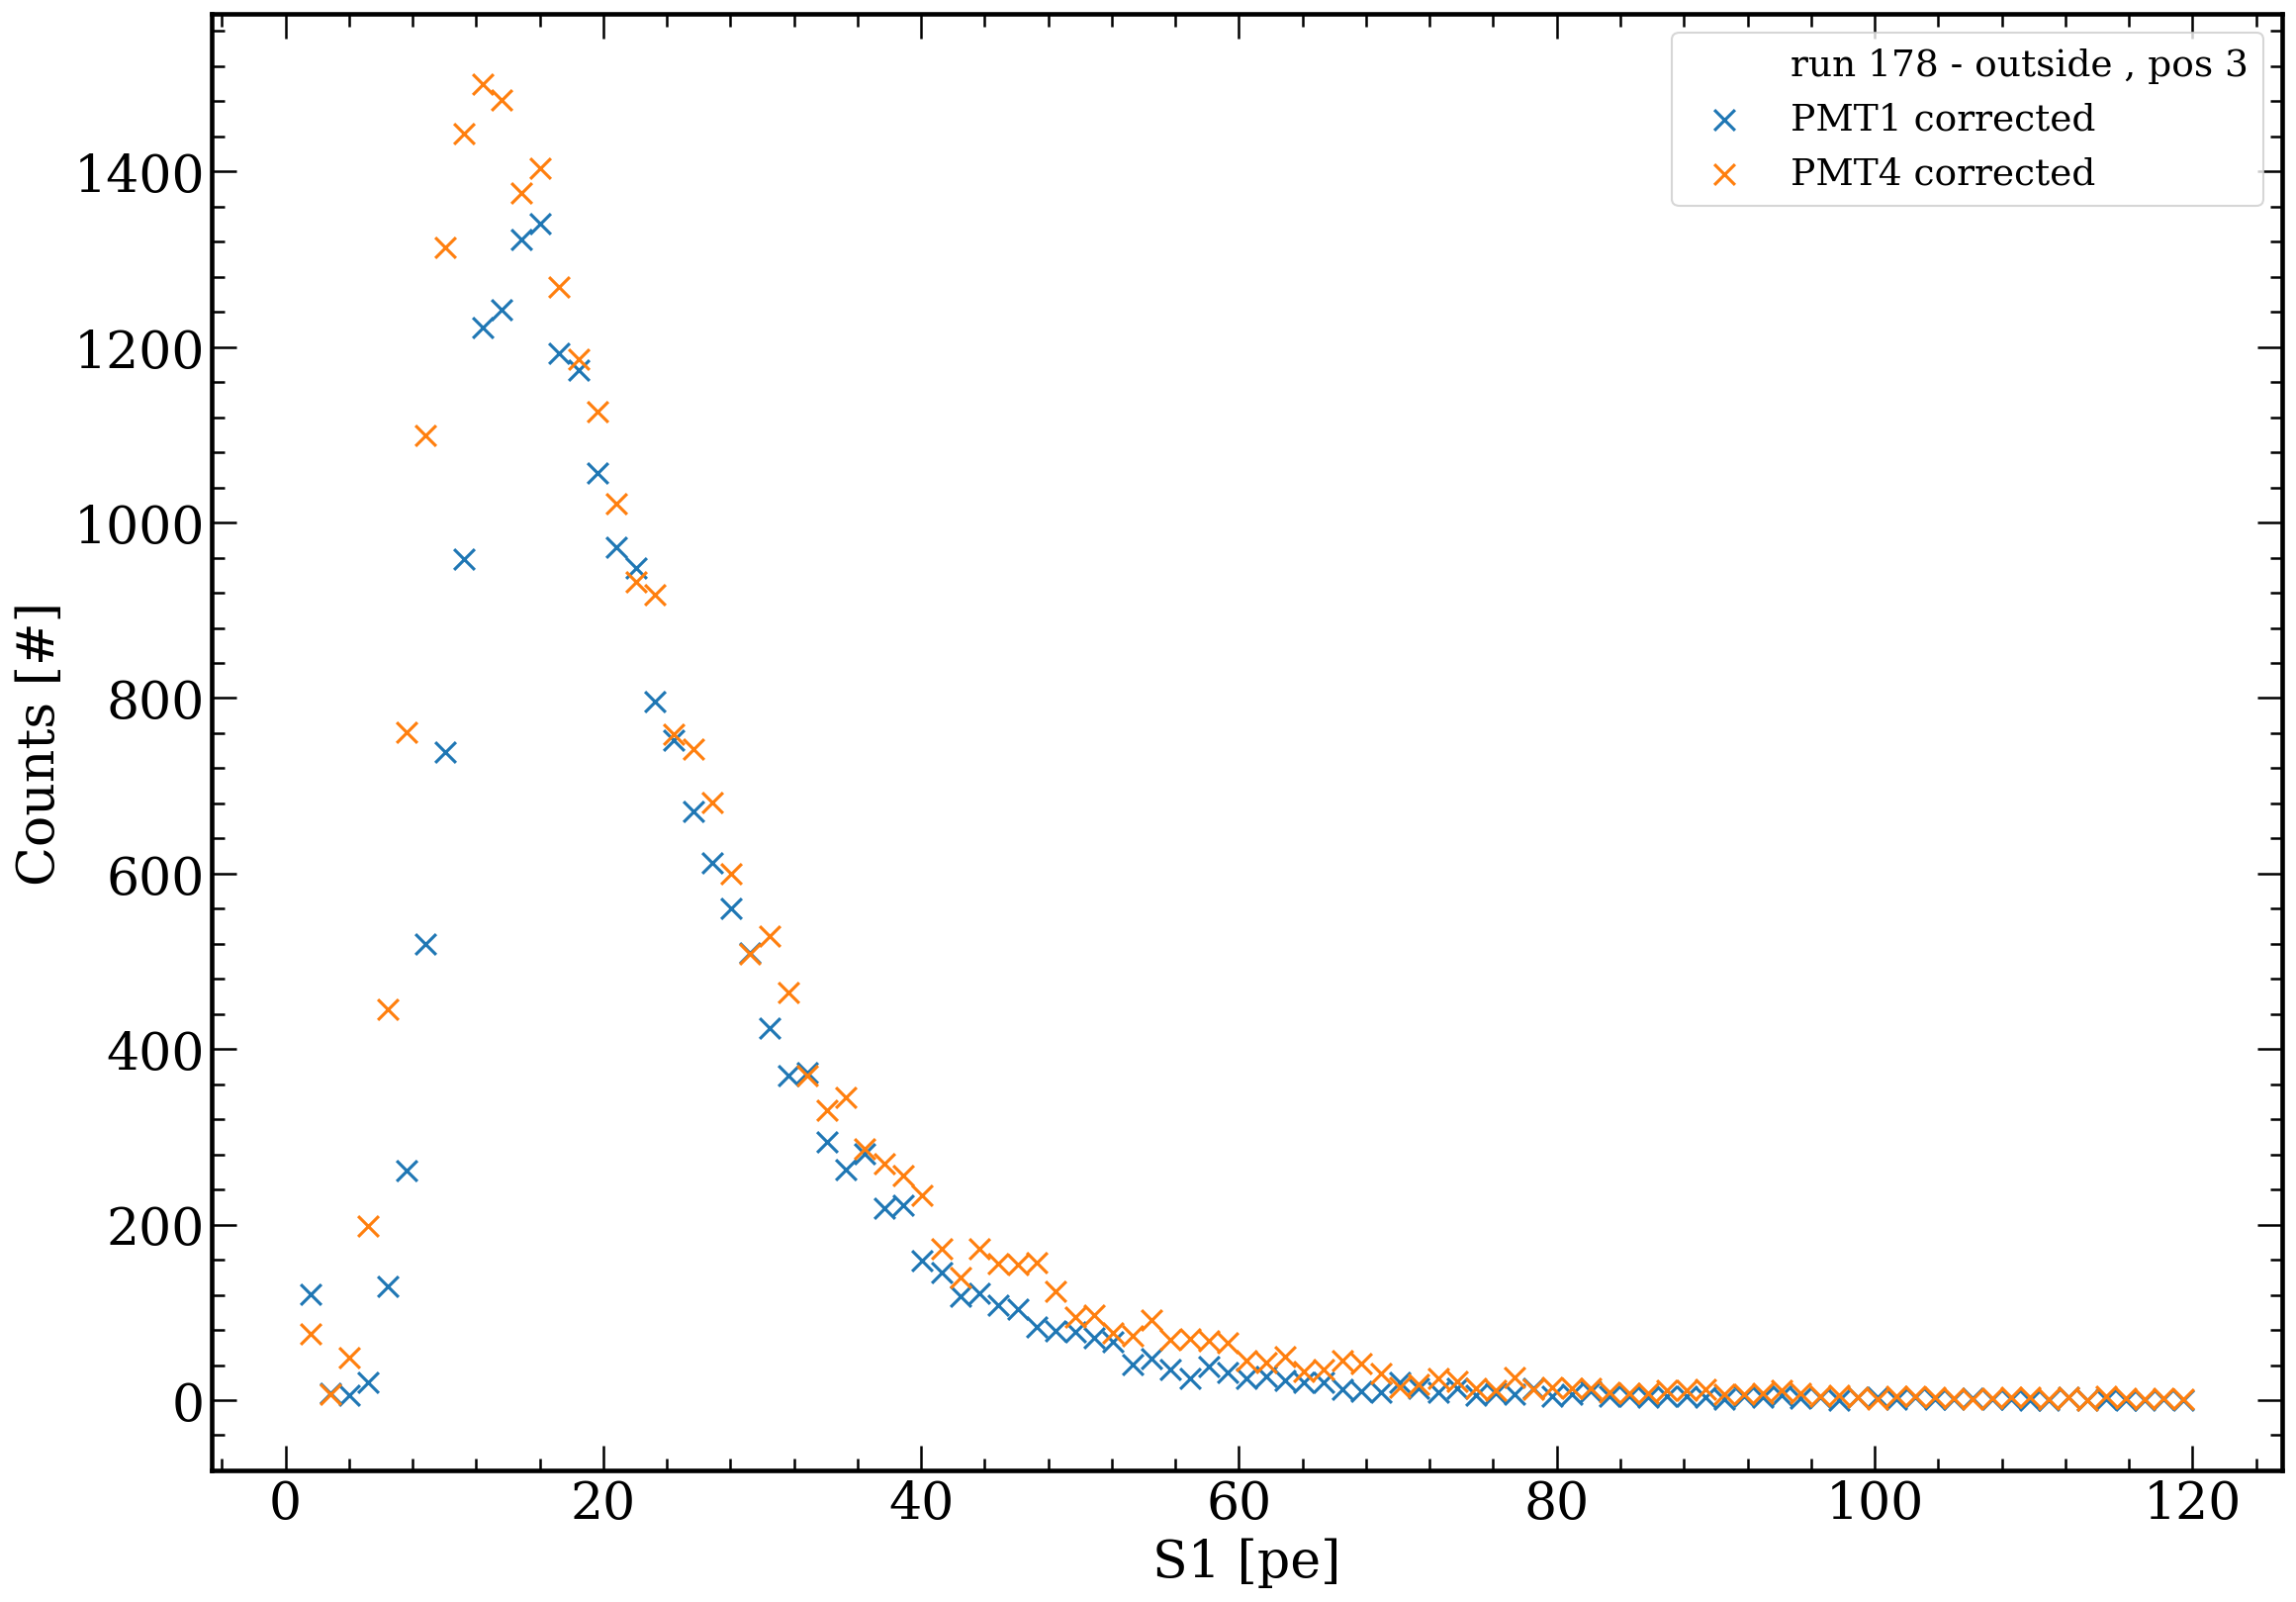

In [194]:
fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


Cs137_range = np.linspace(1, 120,100)
PMT1_corrected, binEdges_corrected_PMT1 = np.histogram(PMTs_S1_corrected_all_runs['00178'][0], bins=Cs137_range)
bincenters_corrected_PMT1 = 0.5 * (binEdges_corrected_PMT1[1:] + binEdges_corrected_PMT1[:-1])

PMT4_corrected, binEdges_corrected_PMT1 = np.histogram(PMTs_S1_corrected_all_runs['00178'][3], bins=Cs137_range)
bincenters_corrected_PMT4 = 0.5 * (binEdges_corrected_PMT1[1:] + binEdges_corrected_PMT1[:-1])


axes.scatter(bincenters_corrected_PMT1, PMT1_corrected , s=100,c = 'C0', marker = 'x', label = 'PMT1 corrected')
axes.scatter(bincenters_corrected_PMT4, PMT4_corrected , s=100,c = 'C1', marker = 'x', label = 'PMT4 corrected')


axes.plot([], [], ' ', label="run 178 - outside , pos 3")
# axes.set_xscale('log')
# axes.set_yscale('log')
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('Counts [#]')
axes.legend(prop={'size': 18})
plt.show()

# Plot opposite side PMTs for 3 different source positions in a single plot

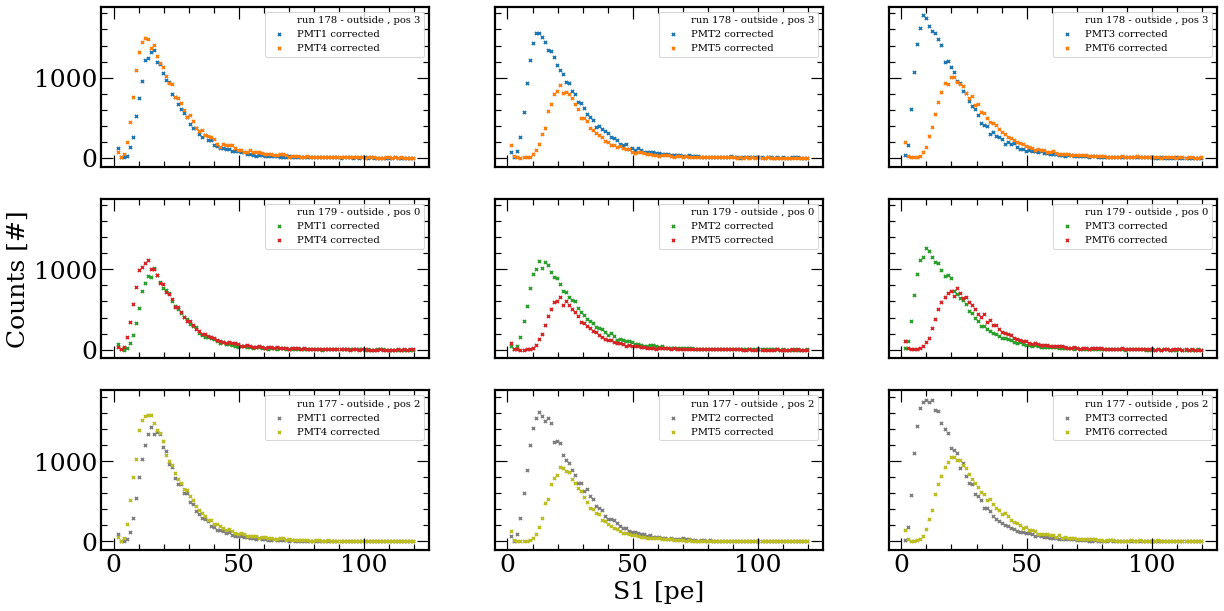

In [195]:
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9]] = plt.subplots(3,3,figsize=(20,10),sharex=True, sharey=True)

#print(axes)

plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

# Labels
label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:

        #ax = plt.gca()
        ax.tick_params(axis = 'both')
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.2)
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5)) 
        ax.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
        ax.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)
    
    
    
###################First row - Position 3#####################    


PMT1_corrected_pos3, binEdges_corrected_PMT1 = np.histogram(PMTs_S1_corrected_all_runs['00178'][0], bins=Cs137_range)
bincenters_corrected_PMT1_pos3 = 0.5 * (binEdges_corrected_PMT1[1:] + binEdges_corrected_PMT1[:-1])
PMT4_corrected_pos3, binEdges_corrected_PMT4 = np.histogram(PMTs_S1_corrected_all_runs['00178'][3], bins=Cs137_range)
bincenters_corrected_PMT4_pos3 = 0.5 * (binEdges_corrected_PMT4[1:] + binEdges_corrected_PMT4[:-1])
ax1.scatter(bincenters_corrected_PMT1_pos3, PMT1_corrected_pos3 , s=10,c = 'C0', marker = 'x', label = 'PMT1 corrected')
ax1.scatter(bincenters_corrected_PMT4_pos3, PMT4_corrected_pos3 , s=10,c = 'C1', marker = 'x', label = 'PMT4 corrected')
ax1.plot([], [], ' ', label="run 178 - outside , pos 3")

PMT2_corrected_pos3, binEdges_corrected_PMT2 = np.histogram(PMTs_S1_corrected_all_runs['00178'][1], bins=Cs137_range)
bincenters_corrected_PMT2_pos3 = 0.5 * (binEdges_corrected_PMT2[1:] + binEdges_corrected_PMT2[:-1])
PMT5_corrected_pos3, binEdges_corrected_PMT5 = np.histogram(PMTs_S1_corrected_all_runs['00178'][4], bins=Cs137_range)
bincenters_corrected_PMT5_pos3 = 0.5 * (binEdges_corrected_PMT5[1:] + binEdges_corrected_PMT5[:-1])
ax2.scatter(bincenters_corrected_PMT2_pos3, PMT2_corrected_pos3 , s=10,c = 'C0', marker = 'x', label = 'PMT2 corrected')
ax2.scatter(bincenters_corrected_PMT5_pos3, PMT5_corrected_pos3 , s=10,c = 'C1', marker = 'x', label = 'PMT5 corrected')
ax2.plot([], [], ' ', label="run 178 - outside , pos 3")

PMT3_corrected_pos3, binEdges_corrected_PMT3 = np.histogram(PMTs_S1_corrected_all_runs['00178'][2], bins=Cs137_range)
bincenters_corrected_PMT3_pos3 = 0.5 * (binEdges_corrected_PMT3[1:] + binEdges_corrected_PMT3[:-1])
PMT6_corrected_pos3, binEdges_corrected_PMT6 = np.histogram(PMTs_S1_corrected_all_runs['00178'][5], bins=Cs137_range)
bincenters_corrected_PMT6_pos3 = 0.5 * (binEdges_corrected_PMT6[1:] + binEdges_corrected_PMT6[:-1])
ax3.scatter(bincenters_corrected_PMT3_pos3, PMT3_corrected_pos3 , s=10,c = 'C0', marker = 'x', label = 'PMT3 corrected')
ax3.scatter(bincenters_corrected_PMT6_pos3, PMT6_corrected_pos3 , s=10,c = 'C1', marker = 'x', label = 'PMT6 corrected')
ax3.plot([], [], ' ', label="run 178 - outside , pos 3")

##################Second row - Position 0 #################

PMT1_corrected_pos0, binEdges_corrected_PMT1 = np.histogram(PMTs_S1_corrected_all_runs['00179'][0], bins=Cs137_range)
bincenters_corrected_PMT1_pos0 = 0.5 * (binEdges_corrected_PMT1[1:] + binEdges_corrected_PMT1[:-1])
PMT4_corrected_pos0, binEdges_corrected_PMT4 = np.histogram(PMTs_S1_corrected_all_runs['00179'][3], bins=Cs137_range)
bincenters_corrected_PMT4_pos0 = 0.5 * (binEdges_corrected_PMT4[1:] + binEdges_corrected_PMT4[:-1])
ax4.scatter(bincenters_corrected_PMT1_pos0, PMT1_corrected_pos0 , s=10,c = 'C2', marker = 'x', label = 'PMT1 corrected')
ax4.scatter(bincenters_corrected_PMT4_pos0, PMT4_corrected_pos0 , s=10,c = 'C3', marker = 'x', label = 'PMT4 corrected')
ax4.plot([], [], ' ', label="run 179 - outside , pos 0")


PMT2_corrected_pos0, binEdges_corrected_PMT2 = np.histogram(PMTs_S1_corrected_all_runs['00179'][1], bins=Cs137_range)
bincenters_corrected_PMT2_pos0 = 0.5 * (binEdges_corrected_PMT2[1:] + binEdges_corrected_PMT2[:-1])
PMT5_corrected_pos0, binEdges_corrected_PMT5 = np.histogram(PMTs_S1_corrected_all_runs['00179'][4], bins=Cs137_range)
bincenters_corrected_PMT5_pos0 = 0.5 * (binEdges_corrected_PMT5[1:] + binEdges_corrected_PMT5[:-1])
ax5.scatter(bincenters_corrected_PMT2_pos0, PMT2_corrected_pos0 , s=10,c = 'C2', marker = 'x', label = 'PMT2 corrected')
ax5.scatter(bincenters_corrected_PMT5_pos0, PMT5_corrected_pos0 , s=10,c = 'C3', marker = 'x', label = 'PMT5 corrected')
ax5.plot([], [], ' ', label="run 179 - outside , pos 0")

PMT3_corrected_pos0, binEdges_corrected_PMT3 = np.histogram(PMTs_S1_corrected_all_runs['00179'][2], bins=Cs137_range)
bincenters_corrected_PMT3_pos0 = 0.5 * (binEdges_corrected_PMT3[1:] + binEdges_corrected_PMT3[:-1])
PMT6_corrected_pos0, binEdges_corrected_PMT6 = np.histogram(PMTs_S1_corrected_all_runs['00179'][5], bins=Cs137_range)
bincenters_corrected_PMT6_pos0 = 0.5 * (binEdges_corrected_PMT6[1:] + binEdges_corrected_PMT6[:-1])
ax6.scatter(bincenters_corrected_PMT3_pos0, PMT3_corrected_pos0 , s=10,c = 'C2', marker = 'x', label = 'PMT3 corrected')
ax6.scatter(bincenters_corrected_PMT6_pos0, PMT6_corrected_pos0 , s=10,c = 'C3', marker = 'x', label = 'PMT6 corrected')
ax6.plot([], [], ' ', label="run 179 - outside , pos 0")

##################Third row row - Position 2 #################

PMT1_corrected_pos2, binEdges_corrected_PMT1 = np.histogram(PMTs_S1_corrected_all_runs['00177'][0], bins=Cs137_range)
bincenters_corrected_PMT1_pos2 = 0.5 * (binEdges_corrected_PMT1[1:] + binEdges_corrected_PMT1[:-1])
PMT4_corrected_pos2, binEdges_corrected_PMT4 = np.histogram(PMTs_S1_corrected_all_runs['00177'][3], bins=Cs137_range)
bincenters_corrected_PMT4_pos2 = 0.5 * (binEdges_corrected_PMT4[1:] + binEdges_corrected_PMT4[:-1])
ax7.scatter(bincenters_corrected_PMT1_pos2, PMT1_corrected_pos2 , s=10,c = 'C7', marker = 'x', label = 'PMT1 corrected')
ax7.scatter(bincenters_corrected_PMT4_pos2, PMT4_corrected_pos2 , s=10,c = 'C8', marker = 'x', label = 'PMT4 corrected')
ax7.plot([], [], ' ', label="run 177 - outside , pos 2")


PMT2_corrected_pos2, binEdges_corrected_PMT2 = np.histogram(PMTs_S1_corrected_all_runs['00177'][1], bins=Cs137_range)
bincenters_corrected_PMT2_pos2 = 0.5 * (binEdges_corrected_PMT2[1:] + binEdges_corrected_PMT2[:-1])
PMT5_corrected_pos2, binEdges_corrected_PMT5 = np.histogram(PMTs_S1_corrected_all_runs['00177'][4], bins=Cs137_range)
bincenters_corrected_PMT5_pos2 = 0.5 * (binEdges_corrected_PMT5[1:] + binEdges_corrected_PMT5[:-1])
ax8.scatter(bincenters_corrected_PMT2_pos2, PMT2_corrected_pos2 , s=10,c = 'C7', marker = 'x', label = 'PMT2 corrected')
ax8.scatter(bincenters_corrected_PMT5_pos2, PMT5_corrected_pos2 , s=10,c = 'C8', marker = 'x', label = 'PMT5 corrected')
ax8.plot([], [], ' ', label="run 177 - outside , pos 2")

PMT3_corrected_pos2, binEdges_corrected_PMT3 = np.histogram(PMTs_S1_corrected_all_runs['00177'][2], bins=Cs137_range)
bincenters_corrected_PMT3_pos2 = 0.5 * (binEdges_corrected_PMT3[1:] + binEdges_corrected_PMT3[:-1])
PMT6_corrected_pos2, binEdges_corrected_PMT6 = np.histogram(PMTs_S1_corrected_all_runs['00177'][5], bins=Cs137_range)
bincenters_corrected_PMT6_pos2 = 0.5 * (binEdges_corrected_PMT6[1:] + binEdges_corrected_PMT6[:-1])
ax9.scatter(bincenters_corrected_PMT3_pos2, PMT3_corrected_pos2 , s=10,c = 'C7', marker = 'x', label = 'PMT3 corrected')
ax9.scatter(bincenters_corrected_PMT6_pos2, PMT6_corrected_pos2 , s=10,c = 'C8', marker = 'x', label = 'PMT6 corrected')
ax9.plot([], [], ' ', label="run 177 - outside , pos 2")




ax8.set_xlabel('S1 [pe]')
ax4.set_ylabel('Counts [#]')

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
    ax.legend(prop={'size': 10})

plt.show()


# Look for reconstructed S2 distribution by Alex implementation

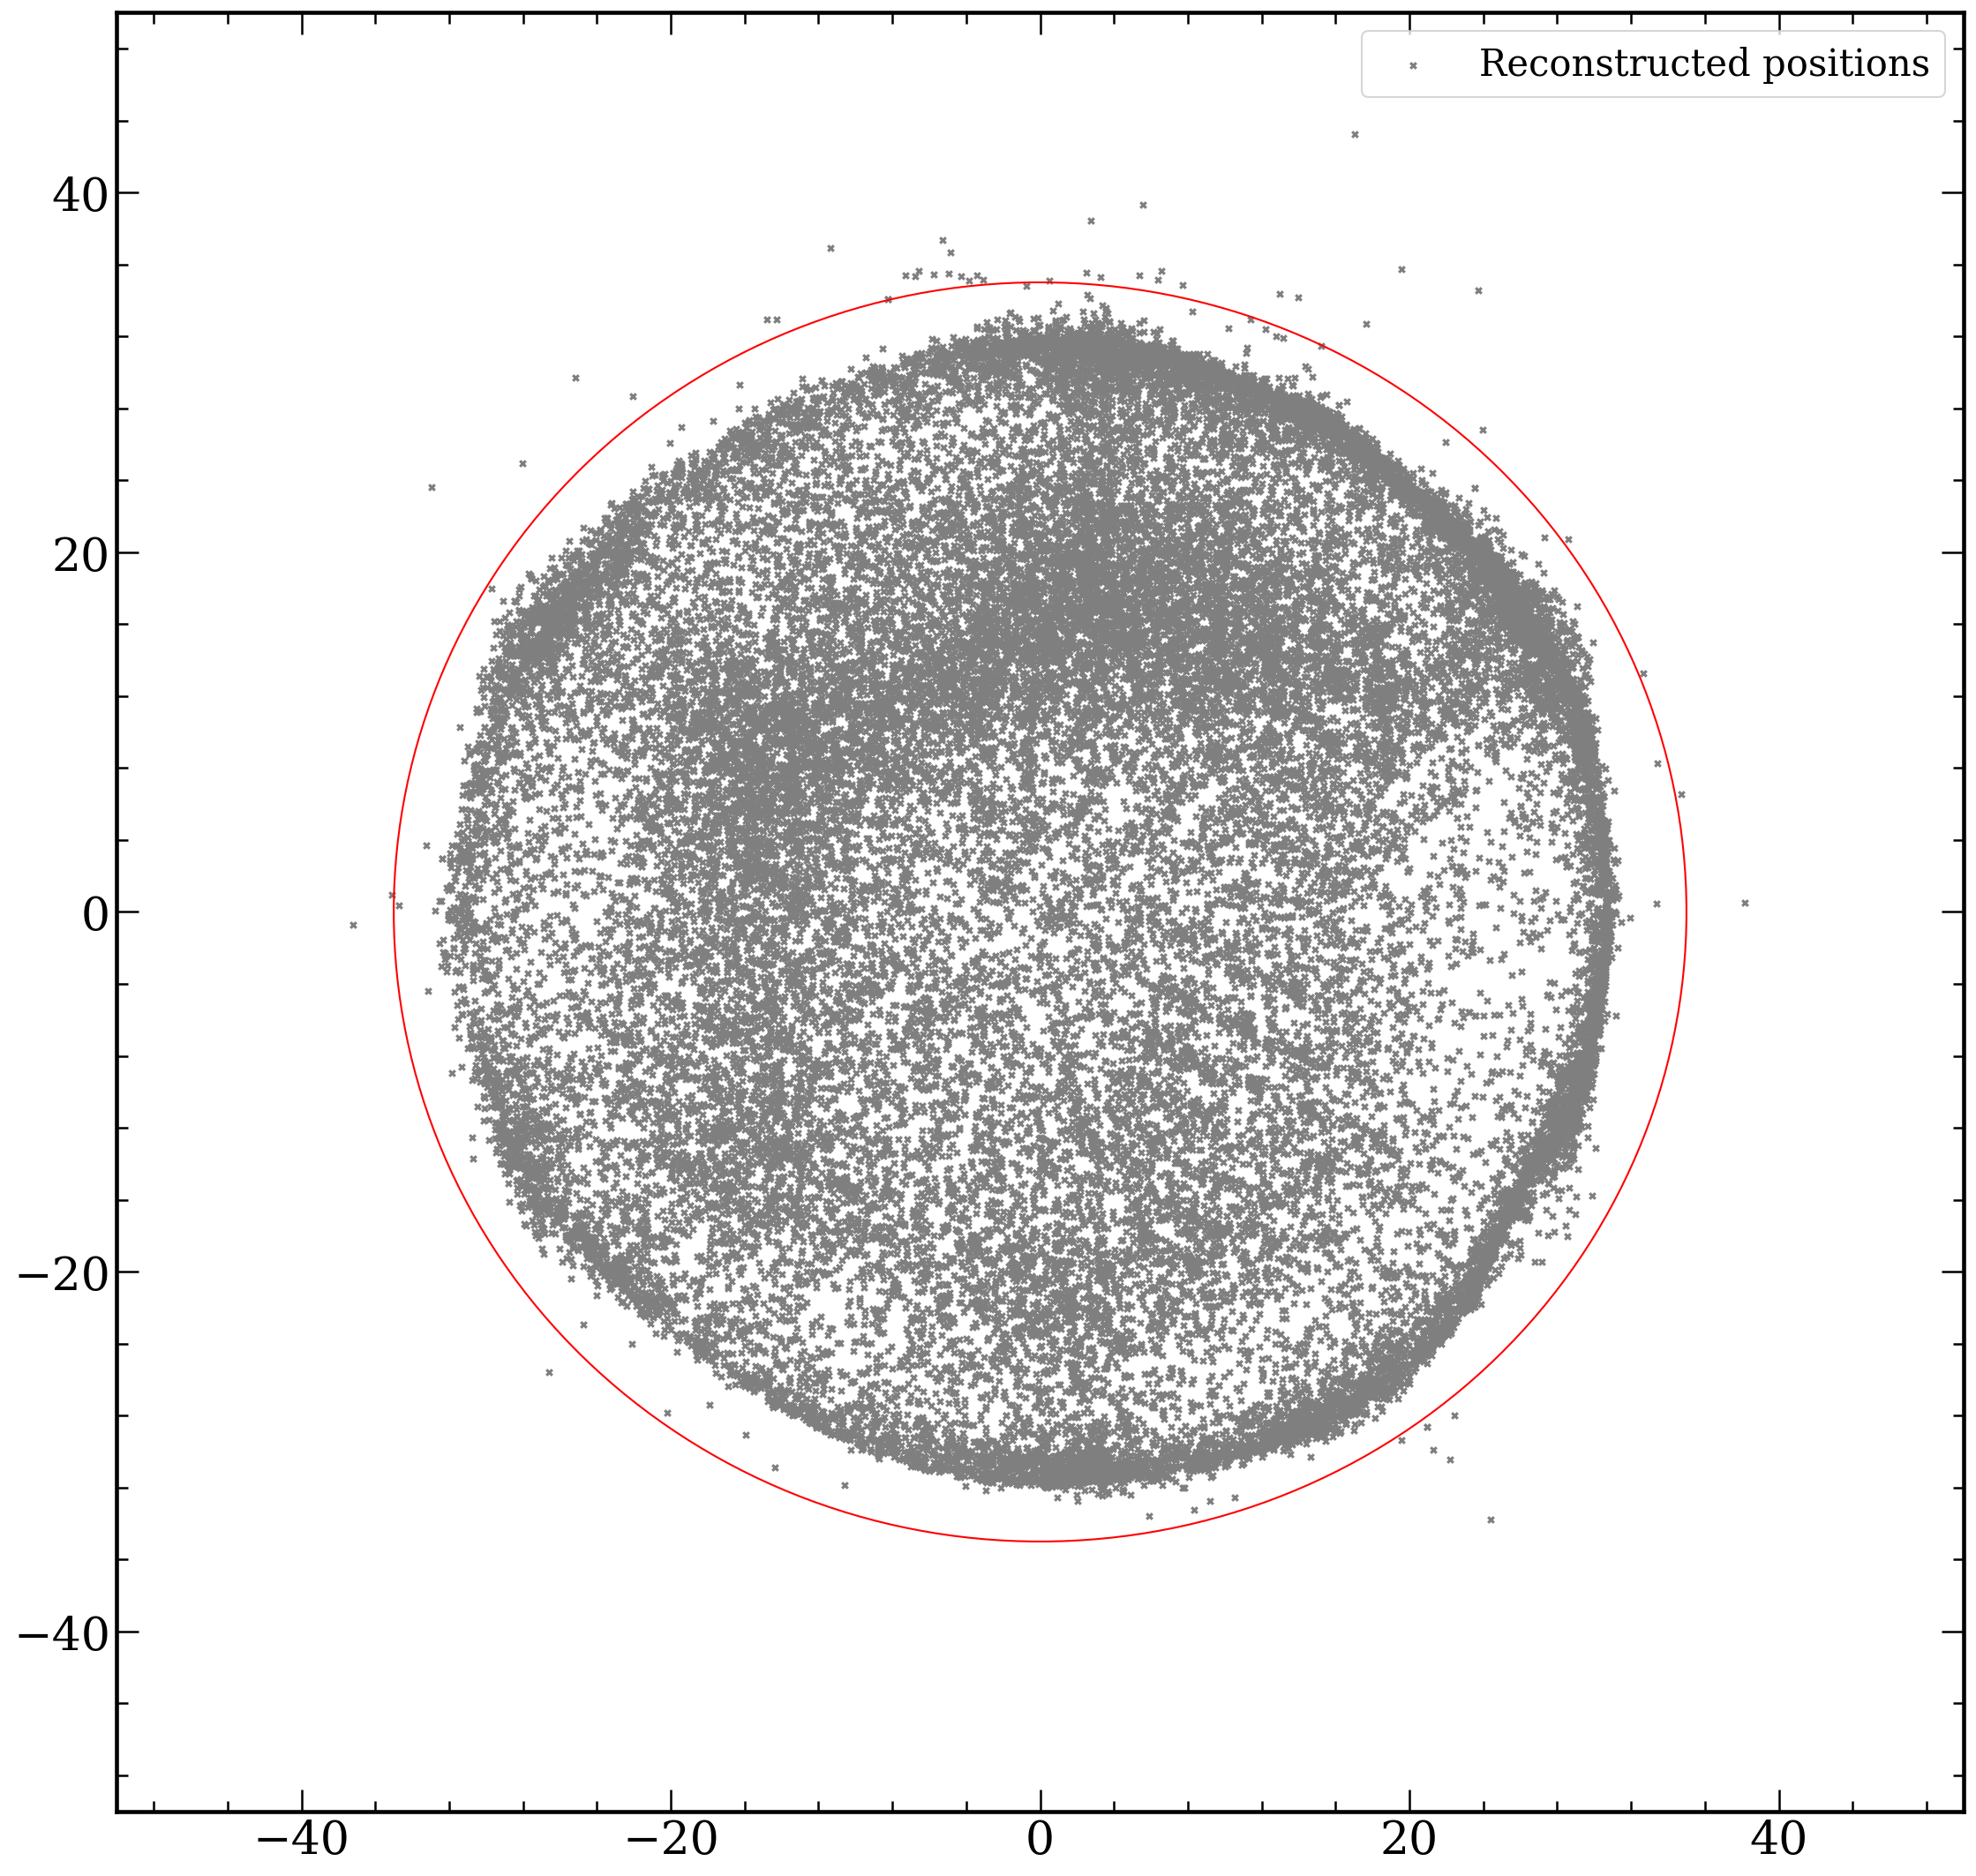

In [196]:
fig=plt.figure(figsize=(18, 18), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

plt.scatter(cs_x_position_all_runs['00178'], cs_y_position_all_runs['00178'],s=10,c = 'C7', marker = 'x', label = 'Reconstructed positions')
circle = plt.Circle((0, 0), 35, color='r', fill=False)
axes.add_artist(circle)
axes.set_xlim([-50,50])
axes.set_ylim([-50,50])
axes.legend(prop={'size': 20})
plt.show()

In [199]:
event_data = ctx.get_array('00178', 'event_basics')

x_position = event_data['x_s2']
y_position = event_data['y_s2']
print(x_position)

ValueError: no field of name x_S2

In [203]:
x_position = event_data['x_s2']
y_position = event_data['y_s2']
print(x_position)
print(len(x_position))

[  4.5249653   8.933827  -13.016709  ...  -4.708874    8.678868
   0.       ]
81250


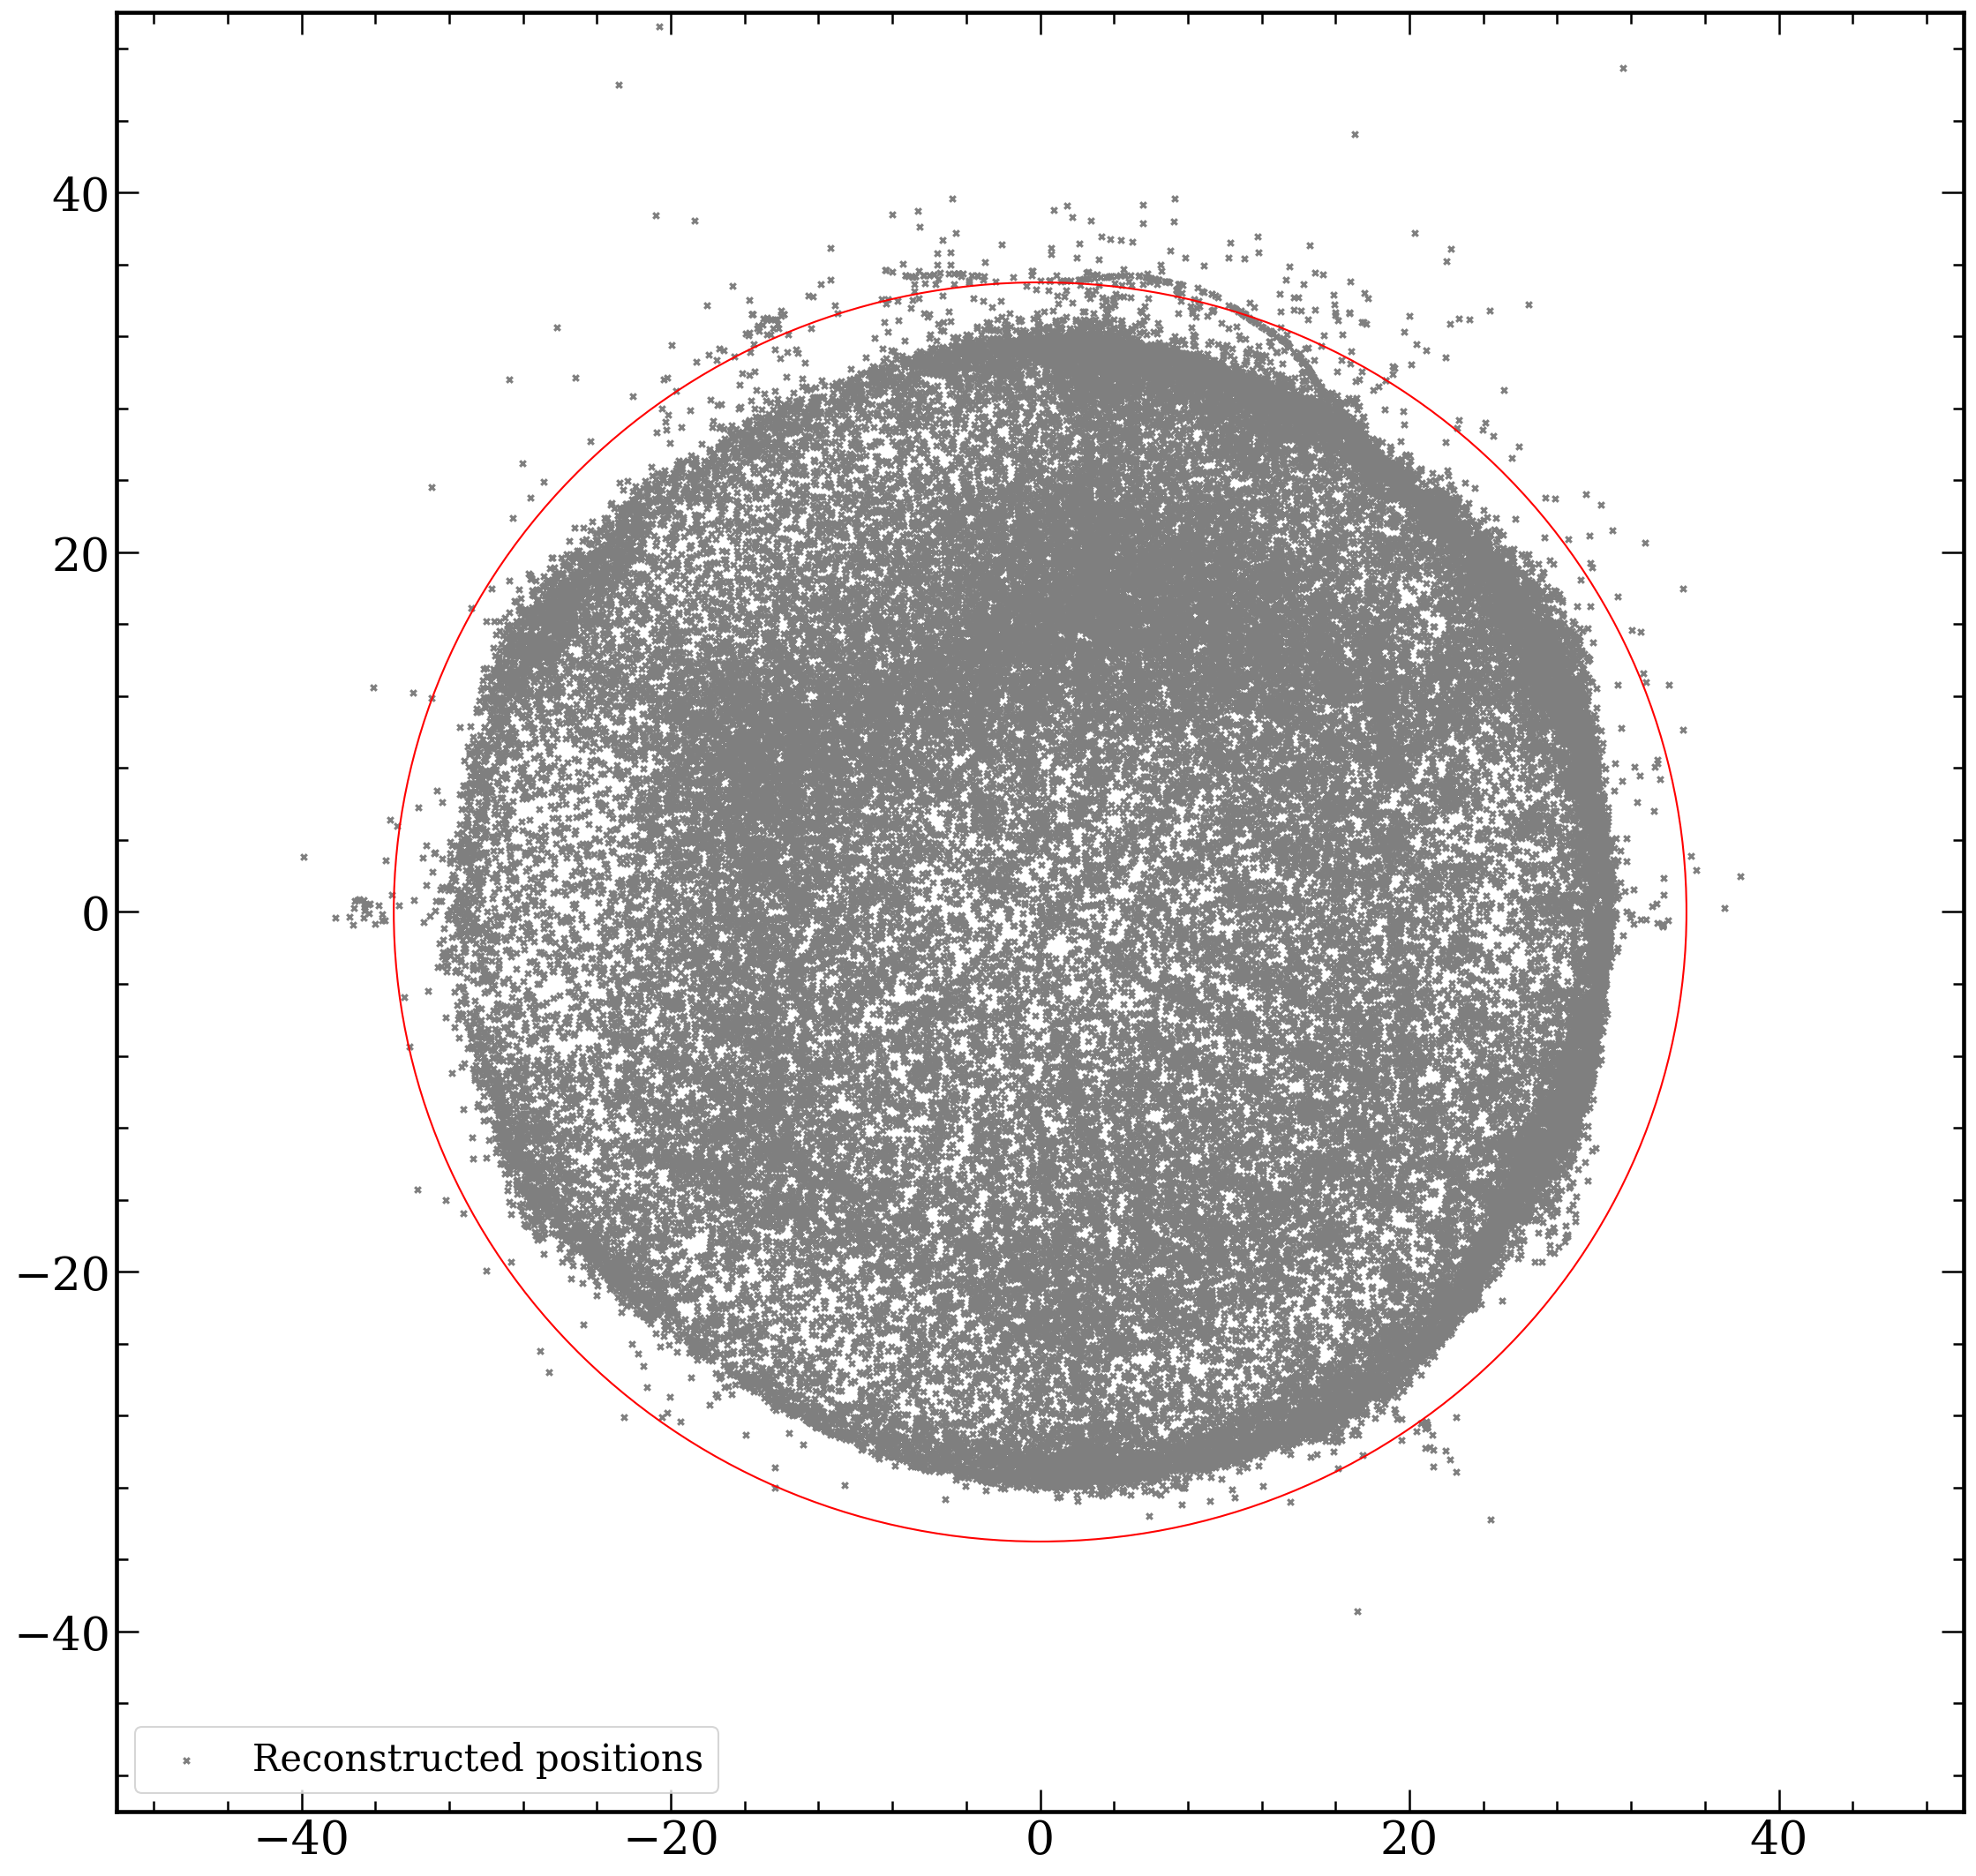

In [202]:
fig=plt.figure(figsize=(18, 18), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

plt.scatter(x_position, y_position,s=10,c = 'C7', marker = 'x', label = 'Reconstructed positions')
circle = plt.Circle((0, 0), 35, color='r', fill=False)
axes.add_artist(circle)
axes.set_xlim([-50,50])
axes.set_ylim([-50,50])
axes.legend(prop={'size': 20})
plt.show()

In [197]:

# print(cs_x_position_all_runs['00178'][:100])
# print(cs_x_position_raw_all_runs['00178'][:100])

[4.5249653, 8.933827, -13.016709, 18.548378, -10.710624, -21.925493, 9.175206, -32.32975, -7.962378, 30.404104, -11.835525, -7.746666, -18.729921, 24.814844, -6.795888, 17.174522, -24.77709, -21.260723, -19.80176, -6.710423, 0.4470816, 18.519186, -0.21875553, -8.55873, -17.865591, -9.847137, 13.970073, -6.3644223, 18.166079, 29.071945, 2.959969, -21.660332, 23.531647, 5.179665, 4.9583306, 9.808456, 23.751904, -10.336492, -26.473015, -12.021163, 29.318266, -15.031279, -27.710138, 11.85368, 5.6656566, 29.93383, 5.6915226, 9.278726, -24.880827, 9.86311, 24.44274, 9.271714, 23.465267, 11.895322, 9.770158, 1.6786828, -17.146013, 21.896362, 26.01893, 20.380272, -13.234285, -17.637339, 18.128902, 16.080154, 9.014383, 23.040817, -22.942915, 3.4135187, -28.130661, -9.140477, 7.944833, 4.1433406, 9.499153, -8.563678, 0.20759039, 7.3281217, -0.005736947, -13.012136, -25.468105, -7.676919, -13.532186, -12.650667, -8.877707, 29.120483, -5.3046365, -11.527734, 14.384894, 26.758072, 28.870329, -15.48

KeyError: '00178'

# Compare with NN function Alex gave me

In [ ]:
data_x = (cs_x_position_raw_all_runs['00178'])*10
data_y = (cs_y_position_raw_all_runs['00178'])*10

fig=plt.figure(figsize=(18, 18), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

plt.scatter(data_x, data_y,s=10,c = 'C7', marker = 'x', label = 'Reconstructed positions')
circle = plt.Circle((0, 0), 35, color='r', fill=False)
axes.add_artist(circle)
axes.set_xlim([-50,50])
axes.set_ylim([-50,50])
axes.legend(prop={'size': 20})
plt.show()

In [ ]:
print(len(cs_drifttime_all_runs['00178']))
print(len(cs_drifttime_all_runs['00177']))
print(len(cs_drifttime_all_runs['00179']))

fig=plt.figure(figsize=(18, 13), dpi=150)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

label_size = 25 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20
axes = plt.gca()
axes.tick_params(axis='both') 
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)


time_limit = 50000
bins = 200

bins_x = np.linspace(0,time_limit,bins)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

cs_drifttime_pos3, binEdges_pos3,_ = plt.hist(cs_drifttime_all_runs['00178'], bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C1', label = 'Position 3')
bincenters_pos3 = 0.5 * (binEdges_pos3[1:] + binEdges_pos3[:-1])

cs_drifttime_pos2, binEdges_pos2,_ = plt.hist(cs_drifttime_all_runs['00177'], bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C3', label = 'Position 2')
bincenters_pos2 = 0.5 * (binEdges_pos2[1:] + binEdges_pos2[:-1])

cs_drifttime_pos0, binEdges_pos0,_ = plt.hist(cs_drifttime_all_runs['00179'], bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C2', label = 'Position 0')
bincenters_pos0 = 0.5 * (binEdges_pos0[1:] + binEdges_pos0[:-1])



axes.set_xlabel('Drifttime [ns]')
axes.set_ylabel('Counts [#]')
axes.legend(loc = 2 ,prop={'size': 20})

plt.show()

# Apply a correlation cut between S1 and S2

In [ ]:
# def reconstructed_position(input_array):
#     ## Normalize sum input to 1 in order to correspond to area fraction in top array
#     HFs_input = input_array / np.sum(input_array)
#     ## Use model to reconstruct position
#     ## Important: Factor 70 for rescaling label
#     predictions = model_NN.predict(np.array([HFs_input]))[0]*70
#     return predictions

In [ ]:
# predict_feature = np.array([0.02448657, 0.04107425, 0.06240126, 0.4399684 , 0.23933649,  0.04107425, 0.15165877])
# reconstructed_position(predict_feature)